<div style="text-align: right">INFO 6106 Neural Modeling, Final Project, Milestone 2</div>
<div style="text-align: right">Lokeshwaran Balamurugan, Nitin Sai Varma Indukuri, Krishica Gopalakrishnan</div>

# Final: Model Comparison and Inference for Hybrid Meteorological Forecasting

<div style="text-align: center;">
    <img src="images\hybrid_meteorological_forecasting_introduction.jpg" width="700" />
</div>


This notebook serves as the culmination of our hybrid meteorological and satellite image forecasting project. Building upon the preprocessed data from our previous data preparation step, we will now focus on comparing various model architectures, conducting inference, and analyzing results.

Our primary objectives in this notebook are:
- Loading the preprocessed hybrid dataset, combining meteorological time-series and satellite imagery.
- Implementing and training multiple models with a hybrid model architecture
- Experimenting with different input window sizes and hyperparameters.
- Evaluating each model using classification metrics such as accuracy and F1-score.
- Generating and analyzing confusion matrices for each model.
- Plotting training and validation loss/accuracy curves to assess model performance and potential overfitting.
- Conducting inference on test data and analyzing the results.
- Comparing the performance of different model architectures and configurations.

Through this comprehensive analysis, we aim to identify the most effective hybrid model for our specific forecasting task. We will explore how different architectures handle the integration of meteorological and satellite data, and how varying input window sizes and model depths impact prediction accuracy.

The insights gained from this notebook will not only help us select the best-performing model but also provide valuable understanding of the strengths and limitations of different hybrid approaches in meteorological forecasting. This knowledge will be crucial for future iterations and potential real-world applications of our forecasting system

**Let us give you a little teaser before we get started:**

We developed six models to tackle the challenge of rainfall prediction, each designed to predict rainfall for different time windows and using distinct weighting approaches.

- **Time Windows:**
  The models are built with three different prediction windows:
  - 24-hour models predict rainfall for the next day.
  - 48-hour models forecast rainfall for the day after next.
  - 72-hour models aim to predict rainfall three days in advance.

- **Weighting Approaches:**
For each time window, we employed two versions:
  - One with automatic class weights, where the model dynamically adjusts for class imbalances.
  - One with manual class weights, where we explicitly define class priorities to handle imbalances.

These six models allow us to evaluate how well the prediction window and weighting strategy impact accuracy and reliability, providing insights into the challenges of forecasting rainfall across different timescales. Let’s dive deeper into their performance!

## 1. Importing Libraries

These libraries are essential for tasks involving data preprocessing, visualization, and model development. Libraries like os, pandas, and numpy facilitate loading, cleaning, and manipulating both meteorological time-series and satellite image data, while pickle helps save and reuse processed datasets or trained models. Image-specific tools like PIL and cv2 enable resizing, augmenting, and transforming satellite images for model input, and SMOTE addresses class imbalance in datasets. Visualization libraries, including matplotlib and seaborn, help track training progress and evaluate model performance using plots such as confusion matrices and learning curves. Lastly, utility libraries like tqdm enhance workflow efficiency with progress bars, and warnings ensures clean, readable outputs by suppressing unnecessary alerts.

In [1]:
# Data Manipulation Libraries
import os
import pandas as pd
import numpy as np
import pickle
import ast

# Plotting Libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

%matplotlib inline

# Image Processing Libraries
from PIL import Image, ImageOps
import cv2

from imblearn.over_sampling import SMOTE

# Utility Libraries
from tqdm import tqdm

# Suppress warnings for cleaner output
import warnings

warnings.filterwarnings("ignore")

## 2. Loading Data

<div style="text-align: center;">
    <img src="images\1660210648644.png" width="700" />
</div>


Now, let's walk through this crucial step in our process. We're loading our preprocessed datasets, which are essential for our model inference.

First, we define our data directory and the window sizes we'll be working with. As you can see, we're using 24-hour, 48-hour, and 72-hour windows for our analysis.

Next, we're using a loop to efficiently load all our datasets. For each window size, we construct the file path and use Python's pickle module to load the data. We're storing these loaded datasets in a dictionary for easy access later. As we load each dataset, we're printing a confirmation message to keep track of our progress.

After loading, we're unpacking these datasets into separate variables. This step is crucial as it allows us to easily access specific components of our data.

In [2]:
# Load datasets for inference
data_dir = "processed_data_pickles"
window_sizes = ["24", "48", "72"]

data_loaded = {}
for window_size in window_sizes:
    file_path = os.path.join(data_dir, f"data_{window_size}_hour.pkl")
    with open(file_path, "rb") as f:
        data_loaded[window_size] = pickle.load(f)
    print(f"Loaded {window_size}-hour dataset from {file_path}")

# Extract datasets
(
    X_train_24,
    y_train_24,
    X_val_24,
    y_val_24,
    X_train_images_24,
    X_val_images_24,
) = data_loaded["24"]
(
    X_train_48,
    y_train_48,
    X_val_48,
    y_val_48,
    X_train_images_48,
    X_val_images_48,
) = data_loaded["48"]
(
    X_train_72,
    y_train_72,
    X_val_72,
    y_val_72,
    X_train_images_72,
    X_val_images_72,
) = data_loaded["72"]

Loaded 24-hour dataset from processed_data_pickles/data_24_hour.pkl
Loaded 48-hour dataset from processed_data_pickles/data_48_hour.pkl
Loaded 72-hour dataset from processed_data_pickles/data_72_hour.pkl


## 3. Hybrid Data Generation

<div style="text-align: center;">
    <img src="images\1695042878723.jpg" width="700" />
</div>



In this section, we implement a custom data generator designed to efficiently handle our hybrid dataset, which includes both meteorological data and satellite imagery. The generator is structured to provide batches of data during training, ensuring that the inputs are correctly formatted and compatible with our model.

It manages the loading of both types of input data and their corresponding labels while also allowing for the incorporation of class weights to address any imbalances in the dataset. Additionally, the generator can shuffle the data at the end of each epoch to enhance model training by presenting the data in varied orders.

Overall, this generator streamlines the process of feeding our multi-input data into the hybrid models, optimizing memory usage and facilitating effective training

In [3]:
from tensorflow.keras.utils import Sequence


class HybridDataGenerator(Sequence):
    def __init__(
        self, X_meteo, X_images, y, batch_size, class_weights=None, shuffle=True
    ):
        """
        Data generator for hybrid models handling meteorological data and 64x64 grayscale images.

        Args:
            X_meteo (np.ndarray): Meteorological input data.
            X_images (np.ndarray): Image input data (shape: (samples, sequence, 64, 64, 1)).
            y (np.ndarray): One-hot encoded target labels.
            batch_size (int): Batch size.
            class_weights (dict, optional): Dictionary of class weights for sample weighting.
            shuffle (bool, optional): Whether to shuffle data at the end of each epoch.
        """
        self.X_meteo = X_meteo.astype(np.float32)
        self.X_images = X_images.astype(np.float32)  # Ensure correct dtype
        self.y = y.astype(np.float32)
        self.batch_size = batch_size
        self.class_weights = class_weights
        self.shuffle = shuffle
        self.indices = np.arange(len(self.X_meteo))
        self.on_epoch_end()

    def __len__(self):
        """
        Number of batches per epoch.
        """
        return int(np.ceil(len(self.X_meteo) / self.batch_size))

    def __getitem__(self, idx):
        """
        Generate one batch of data.

        Args:
            idx (int): Batch index.

        Returns:
            tuple: Batch of inputs, labels, and sample weights.
        """
        start = idx * self.batch_size
        end = min(start + self.batch_size, len(self.X_meteo))
        batch_indices = self.indices[start:end]

        batch_X_meteo = self.X_meteo[batch_indices]  # Meteorological data
        batch_X_images = self.X_images[batch_indices]  # 64x64 image data
        batch_y = self.y[batch_indices]  # Labels

        # Compute sample weights (if class weights are provided)
        if self.class_weights:
            batch_sample_weights = np.array(
                [self.class_weights[np.argmax(label)] for label in batch_y]
            )
        else:
            batch_sample_weights = np.ones(
                len(batch_y)
            )  # Uniform weights if not provided

        return (
            {"meteo_input": batch_X_meteo, "cloud_input": batch_X_images},
            batch_y,
            batch_sample_weights,
        )

    def on_epoch_end(self):
        """
        Shuffle indices after each epoch if shuffle is enabled.
        """
        if self.shuffle:
            np.random.shuffle(self.indices)

Here, we're setting up our validation data generators for different time windows. We create separate generators for 24-hour, 48-hour, and 72-hour windows, each using our custom HybridDataGenerator class.

For each generator, we're feeding in the corresponding validation data: meteorological features, satellite images, and labels. We're using a batch size of 32 for all generators.

Importantly, we've set 'shuffle' to False for these validation generators. This ensures that our validation data remains in a consistent order, which is crucial for reliable model evaluation

In [4]:
# Instantiate the validation generator for 24 windows
val_generator_24 = HybridDataGenerator(
    X_val_24,
    X_val_images_24,
    y_val_24,
    32,
    class_weights=None,
    shuffle=False,  # class_weights can be None or omitted
)

# Instantiate the validation generator for 48 windows
val_generator_48 = HybridDataGenerator(
    X_val_48,
    X_val_images_48,
    y_val_48,
    32,
    class_weights=None,
    shuffle=False,  # class_weights can be None or omitted
)

# Instantiate the validation generator for 72 windows
val_generator_72 = HybridDataGenerator(
    X_val_72,
    X_val_images_72,
    y_val_72,
    32,
    class_weights=None,
    shuffle=False,  # class_weights can be None or omitted
)

### Helper: Plot Training History

Let us define a helper function that visualizes the training progress of a machine learning model by plotting training and validation accuracy and loss over epochs. It creates a two-panel figure: the top panel shows loss curves, and the bottom panel displays accuracy curves for both training and validation data. 

We will be utilizing this function a lot, to assess the performance of our model.

In [5]:
def plot_training_history(history, title):
    """
    Plots training and validation accuracy and loss from a history dictionary.

    Args:
        history (dict): Dictionary containing 'accuracy', 'val_accuracy', 'loss', 'val_loss'.
        title (str): Title for the plots.
    """
    epochs = range(1, len(history["accuracy"]) + 1)

    fig, axes = plt.subplots(
        2, 1, figsize=(8, 10)
    )  # Two rows, one column for compact layout
    fig.suptitle(title, fontsize=16)

    # Loss Plot
    axes[0].plot(epochs, history["loss"], label="Training Loss", marker="o")
    axes[0].plot(epochs, history["val_loss"], label="Validation Loss", marker="o")
    axes[0].set_title("Loss Over Epochs")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[0].grid(True)

    # Accuracy Plot
    axes[1].plot(epochs, history["accuracy"], label="Training Accuracy", marker="o")
    axes[1].plot(
        epochs, history["val_accuracy"], label="Validation Accuracy", marker="o"
    )
    axes[1].set_title("Accuracy Over Epochs")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit suptitle
    plt.show()

## 4. 24-Hour Window  Hybrid Model

Since our objective is to predict outcomes based on both meteorological and satellite image data, we are building a **Hybrid Model** that takes in the past **24-hour input**, and predicts the rainfall category for the **next day**. We need it to efficiently integrate spatiotemporal data into a unified architecture. Here's how we approach the design:

### 4.1 Model Architecture

---

### **Key Components of the Model**

#### **Input Layers**
- The model consists of **two input layers**:
  - One for **meteorological data**: 24-hour time-series with 10 features.
  - One for **cloud image sequences**: 8 images per sequence, each of size 64x64x1.

---

#### **Architecture**
1. **ConvLSTM for Cloud Data**  
   - Extracts spatial and temporal features from the satellite image sequences.
   - Two **ConvLSTM2D** layers with dropout for regularization to capture spatiotemporal patterns.
   - A **TimeDistributed Flatten layer** to reduce spatial dimensions, followed by an **LSTM layer** for summarizing temporal features.
   - Batch normalization stabilizes the training process.

2. **LSTM with Attention for Meteorological Data**  
   - Two **LSTM layers** are used to process meteorological time-series data, with dropout to mitigate overfitting.
   - An **attention mechanism** highlights the most critical time steps, improving the model's focus on key temporal patterns.
   - A final **LSTM layer** summarizes the attention-weighted features into a fixed-size representation.
   - Batch normalization is applied to maintain stability.

3. **Feature Combination**  
   - Features from both meteorological and cloud data streams are **concatenated** to create a unified representation.
   - Dense layers refine these combined features, with additional dropout layers for regularization.

---

#### **Output Layer**
- The model includes a **Dense layer** with a softmax activation function to classify data into the target categories.
- It produces a **single prediction** for the input, tailored to the respective time window.

---

### **Implementation Details**
- The model is compiled with the **Adam optimizer**, a learning rate of `0.0001`, and categorical crossentropy as the loss function.
- Metrics include accuracy to evaluate performance.


In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    ConvLSTM2D,
    LSTM,
    Dense,
    Dropout,
    BatchNormalization,
    Flatten,
    Add,
    Reshape,
    TimeDistributed,
    Attention,
    Concatenate,
)
from tensorflow.keras.optimizers import Adam


def hybrid_model_optimized_24(num_classes):
    """
    Hybrid model combining ConvLSTM for cloud image sequences and LSTM for meteorological data.
    """
    # Input for meteorological data
    meteo_input = Input(shape=(24, 10), name="meteo_input")

    # Input for cloud image data
    cloud_input = Input(shape=(8, 64, 64, 1), name="cloud_input")

    # --- ConvLSTM for Cloud Data ---
    def feature_extractor_images(input_layer):
        x = ConvLSTM2D(
            filters=8, kernel_size=(3, 3), padding="same", return_sequences=True
        )(input_layer)
        x = Dropout(0.25)(x)

        x = ConvLSTM2D(
            filters=16, kernel_size=(3, 3), padding="same", return_sequences=True
        )(x)
        x = Dropout(0.25)(x)

        x = TimeDistributed(Flatten())(x)
        x = LSTM(64, return_sequences=False)(x)
        x = BatchNormalization()(x)
        return x

    # --- LSTM with Attention for Meteorological Data ---
    def feature_extractor_meteo(input_layer):
        x = LSTM(128, return_sequences=True)(input_layer)
        x = Dropout(0.25)(x)

        x = LSTM(64, return_sequences=True)(x)
        x = Dropout(0.25)(x)

        # Adding attention over time steps
        attention = Attention()([x, x])
        x = LSTM(64, return_sequences=False)(attention)
        x = BatchNormalization()(x)
        return x

    # Extract features from inputs
    cloud_features = feature_extractor_images(cloud_input)
    meteo_features = feature_extractor_meteo(meteo_input)

    # --- Combine Features ---
    combined_features = Concatenate()([meteo_features, cloud_features])

    # --- Decoder Layers ---
    x = Dense(128, activation="relu")(combined_features)
    x = Dropout(0.25)(x)

    x = Dense(64, activation="relu")(x)
    x = Dropout(0.25)(x)

    # Output layer
    output = Dense(num_classes, activation="softmax", name="output")(x)

    # Define model
    model = Model(inputs=[cloud_input, meteo_input], outputs=output)

    return model


# Instantiate the model
num_classes = 4

# Compile the model
optimizer = Adam(learning_rate=0.0001)

model_automatic_weights_24 = hybrid_model_optimized_24(num_classes)

model_automatic_weights_24.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

# Display model summary
model_automatic_weights_24.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ meteo_input         │ (None, 24, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cloud_input         │ (None, 8, 64, 64, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 24, 128)   │     71,168 │ meteo_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d         │ (None, 8, 64, 64, │      2,624 │ cloud_input[0][0] │
│ (ConvLSTM2D)        │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 24, 128)   │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 8, 64, 64, │          0 │ conv_lstm2d[0][0] │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 24, 64)    │     49,408 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_1       │ (None, 8, 64, 64, │     13,888 │ dropout[0][0]     │
│ (ConvLSTM2D)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 24, 64)    │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8, 64, 64, │          0 │ conv_lstm2d_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 24, 64)    │          0 │ dropout_3[0][0],  │
│ (Attention)         │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 8, 65536)  │          0 │ dropout_1[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 64)        │     33,024 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │ 16,793,856 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ lstm_3[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64)        │        256 │ lstm[0][0]        │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 16,989,508 (64.81 MB)

 Trainable params: 16,989,252 (64.81 MB)

 Non-trainable params: 256 (1.00 KB)

### 4.2 Loading 24-Hour Window Model (with automatic weights)

Let us load the 24-hour window model, and use it to predict the category of rainfall, for the next day.

In [7]:
weights_path = (
    "24_automatic_weights/24_window_hybrid_model_automatic_weights_epoch_10.h5"
)

# Load the weights
model_automatic_weights_24.load_weights(weights_path)

print("Weights successfully loaded!")

Weights successfully loaded!


In [8]:
model_manual_weights_24 = hybrid_model_optimized_24(num_classes)

model_manual_weights_24.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

weights_path = "24_manual_weights/24_window_hybrid_model_manual_weights_epoch_10_additional10.keras"

# Load the weights
model_manual_weights_24.load_weights(weights_path)

print("Weights successfully loaded!")

Weights successfully loaded!


### 4.3 Training and Validation Curves

Now, Let's evaluate the performance of the 24-Hour Model with automatic weights and manual weights, and compare their results.

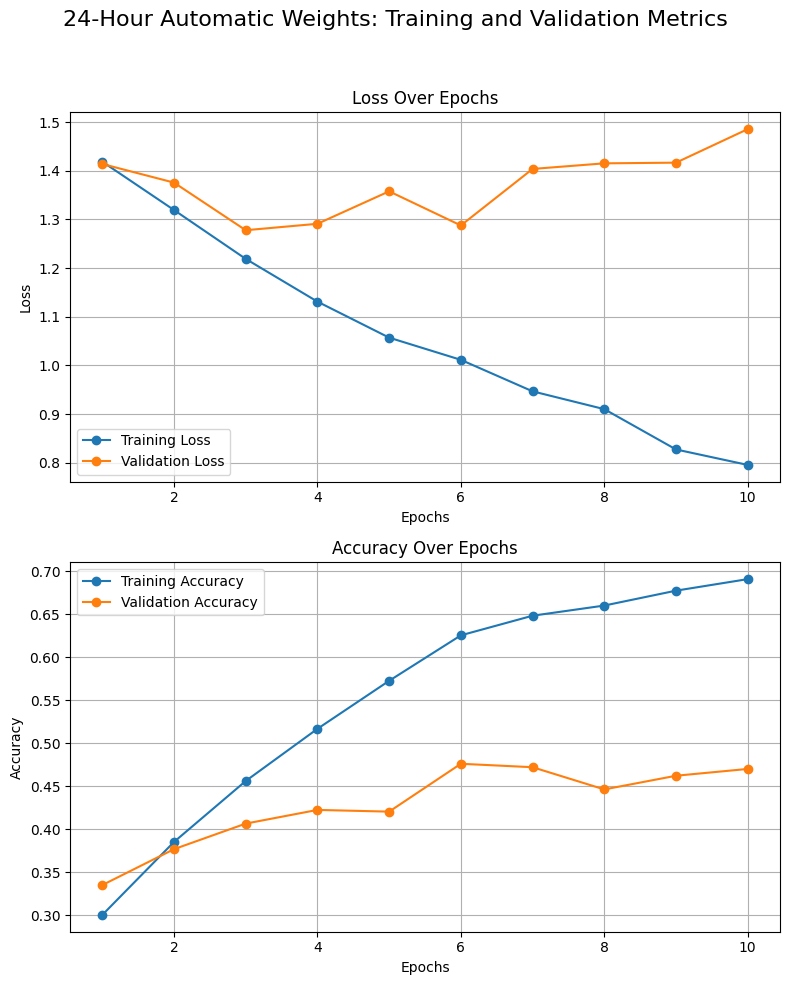

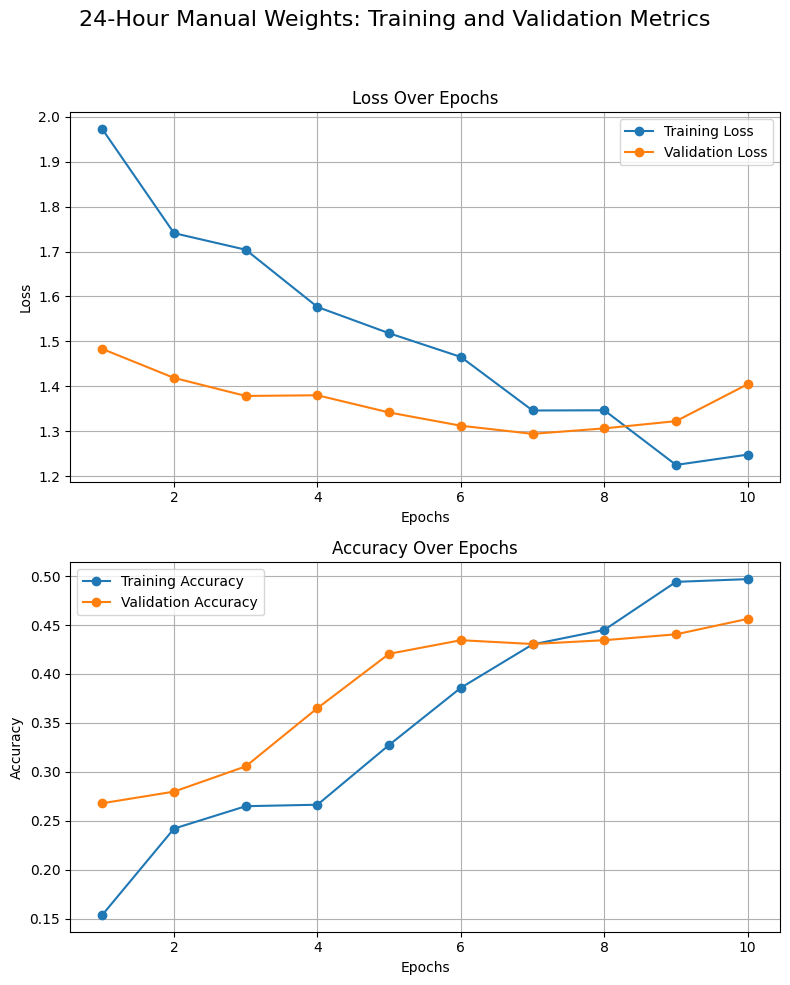

In [9]:
# Manually hard-code the metrics
history_24_auto = {
    "accuracy": [
        0.3006,
        0.3854,
        0.4562,
        0.5168,
        0.5726,
        0.6254,
        0.6482,
        0.6600,
        0.6773,
        0.6907,
    ],
    "val_accuracy": [
        0.3353,
        0.3770,
        0.4067,
        0.4226,
        0.4206,
        0.4762,
        0.4722,
        0.4464,
        0.4623,
        0.4702,
    ],
    "loss": [
        1.4186,
        1.3193,
        1.2189,
        1.1311,
        1.0571,
        1.0115,
        0.9468,
        0.9102,
        0.8274,
        0.7956,
    ],
    "val_loss": [
        1.4139,
        1.3756,
        1.2778,
        1.2910,
        1.3577,
        1.2876,
        1.4037,
        1.4152,
        1.4166,
        1.4855,
    ],
}

history_24_manual = {
    "accuracy": [
        0.1538,
        0.2420,
        0.2649,
        0.2664,
        0.3275,
        0.3859,
        0.4302,
        0.4450,
        0.4941,
        0.4969,
    ],
    "val_accuracy": [
        0.2679,
        0.2798,
        0.3056,
        0.3651,
        0.4206,
        0.4345,
        0.4306,
        0.4345,
        0.4405,
        0.4563,
    ],
    "loss": [
        1.9726,
        1.7410,
        1.7041,
        1.5766,
        1.5181,
        1.4653,
        1.3461,
        1.3466,
        1.2249,
        1.2479,
    ],
    "val_loss": [
        1.4832,
        1.4187,
        1.3785,
        1.3800,
        1.3417,
        1.3122,
        1.2941,
        1.3063,
        1.3224,
        1.4047,
    ],
}

# Plot for 24-Hour Automatic Weights
plot_training_history(
    history_24_auto, "24-Hour Automatic Weights: Training and Validation Metrics"
)

# Plot for 24-Hour Manual Weights
plot_training_history(
    history_24_manual, "24-Hour Manual Weights: Training and Validation Metrics"
)

Let's look at the accuracy and loss curves, shall we?

**Accuracy Curve:**

- **Automatic Weights:** The model consistently improves its accuracy on both training and validation sets, reaching a peak validation accuracy of around 0.47. This suggests that the automatic weight update strategy effectively learns from the data.
- **Manual Weights:** The model also shows an upward trend in accuracy, but its performance is generally lower than the automatic model. The validation accuracy peaks at around 0.46, indicating that manual tuning, while potentially beneficial, may not be as effective as automated optimization.

**Loss Plot:**

- **Automatic Weights**: The model's loss decreases steadily on both training and validation sets. This indicates that the model is learning to make more accurate predictions over time.
- **Manual Weights:** The loss also decreases, but it exhibits more fluctuations compared to the automatic model. The validation loss shows a slight increase towards the end of training.

**What can we infer from this?** 

We can say that the the model with automatic weight updates demonstrates superior performance in terms of both accuracy and loss. It is able to learn more effectively from the rainfall data and generalize better to unseen data.

## 5. 48-Hour Window Hybrid Model

Since our objective is to predict outcomes based on both meteorological and satellite image data, we are building a **Hybrid Model** that takes in the past **48-hour input**, and predicts the rainfall category for the **next-to-next day**. We need it to efficiently integrate spatiotemporal data into a unified architecture. Here's how we approach the design:

### 5.1 Model Architecture

---

### **Key Components of the Model**

#### **Input Layers**
- The model consists of **two input layers**:
  - One for **meteorological data**: 48-hour time-series with 10 features.
  - One for **cloud image sequences**: 16 images per sequence, each of size 64x64x1.

---

#### **Architecture**
1. **ConvLSTM for Cloud Data**  
   - Extracts spatial and temporal features from the satellite image sequences.
   - Two **ConvLSTM2D** layers with dropout for regularization to capture spatiotemporal patterns.
   - A **TimeDistributed Flatten layer** to reduce spatial dimensions, followed by an **LSTM layer** for summarizing temporal features.
   - Batch normalization stabilizes the training process.

2. **LSTM with Attention for Meteorological Data**  
   - Two **LSTM layers** are used to process meteorological time-series data, with dropout to mitigate overfitting.
   - An **attention mechanism** highlights the most critical time steps, improving the model's focus on key temporal patterns.
   - A final **LSTM layer** summarizes the attention-weighted features into a fixed-size representation.
   - Batch normalization is applied to maintain stability.

3. **Feature Combination**  
   - Features from both meteorological and cloud data streams are **concatenated** to create a unified representation.
   - Dense layers refine these combined features, with additional dropout layers for regularization.

---

#### **Output Layer**
- The model includes a **Dense layer** with a softmax activation function to classify data into the target categories.
- It produces a **single prediction** for the input, tailored to the respective time window.

---

### **Implementation Details**
- The model is compiled with the **Adam optimizer**, a learning rate of `0.0001`, and categorical crossentropy as the loss function.
- Metrics include accuracy to evaluate performance.


In [10]:
def hybrid_model_optimized_48(num_classes):
    """
    Hybrid model combining ConvLSTM for cloud image sequences and LSTM for meteorological data.
    """
    # Input for meteorological data
    meteo_input = Input(shape=(48, 10), name="meteo_input")

    # Input for cloud image data
    cloud_input = Input(shape=(16, 64, 64, 1), name="cloud_input")

    # --- ConvLSTM for Cloud Data ---
    def feature_extractor_images(input_layer):
        x = ConvLSTM2D(
            filters=8, kernel_size=(3, 3), padding="same", return_sequences=True
        )(input_layer)
        x = Dropout(0.25)(x)

        x = ConvLSTM2D(
            filters=16, kernel_size=(3, 3), padding="same", return_sequences=True
        )(x)
        x = Dropout(0.25)(x)

        x = TimeDistributed(Flatten())(x)
        x = LSTM(64, return_sequences=False)(x)
        x = BatchNormalization()(x)
        return x

    # --- LSTM with Attention for Meteorological Data ---
    def feature_extractor_meteo(input_layer):
        x = LSTM(128, return_sequences=True)(input_layer)
        x = Dropout(0.25)(x)

        x = LSTM(64, return_sequences=True)(x)
        x = Dropout(0.25)(x)

        # Adding attention over time steps
        attention = Attention()([x, x])
        x = LSTM(64, return_sequences=False)(attention)
        x = BatchNormalization()(x)
        return x

    # Extract features from inputs
    cloud_features = feature_extractor_images(cloud_input)
    meteo_features = feature_extractor_meteo(meteo_input)

    # --- Combine Features ---
    combined_features = Concatenate()([meteo_features, cloud_features])

    # --- Decoder Layers ---
    x = Dense(128, activation="relu")(combined_features)
    x = Dropout(0.25)(x)

    x = Dense(64, activation="relu")(x)
    x = Dropout(0.25)(x)

    # Output layer
    output = Dense(num_classes, activation="softmax", name="output")(x)

    # Define model
    model = Model(inputs=[cloud_input, meteo_input], outputs=output)

    return model


# Instantiate the model
num_classes = 4

# Compile the model
optimizer = Adam(learning_rate=0.0001)

model_automatic_weights_48 = hybrid_model_optimized_48(num_classes)

model_automatic_weights_48.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

# Display model summary
model_automatic_weights_48.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ meteo_input         │ (None, 48, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cloud_input         │ (None, 16, 64,    │          0 │ -                 │
│ (InputLayer)        │ 64, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 48, 128)   │     71,168 │ meteo_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_4       │ (None, 16, 64,    │      2,624 │ cloud_input[0][0] │
│ (ConvLSTM2D)        │ 64, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 48, 128)   │          0 │ lstm_9[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 16, 64,    │          0 │ conv_lstm2d_4[0]… │
│ (Dropout)           │ 64, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ (None, 48, 64)    │     49,408 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_5       │ (None, 16, 64,    │     13,888 │ dropout_12[0][0]  │
│ (ConvLSTM2D)        │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 48, 64)    │          0 │ lstm_10[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 16, 64,    │          0 │ conv_lstm2d_5[0]… │
│ (Dropout)           │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_2         │ (None, 48, 64)    │          0 │ dropout_15[0][0], │
│ (Attention)         │                   │            │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 16, 65536) │          0 │ dropout_13[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ (None, 64)        │     33,024 │ attention_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 64)        │ 16,793,856 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ lstm_11[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ lstm_8[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 128)       │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     16,512 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 16,989,508 (64.81 MB)

 Trainable params: 16,989,252 (64.81 MB)

 Non-trainable params: 256 (1.00 KB)

### 5.2 Loading 48-Hour Window Models

We have already built a 48-Hour Model with automatic and manual class weights. Why don't we load both the models, and evaluate how they are performing.

In [11]:
weights_path = (
    "48_automatic_weights/48_window_hybrid_model_automatic_weights_epoch_20.keras"
)

# Load the weights
model_automatic_weights_48.load_weights(weights_path)

print("Weights successfully loaded!")

Weights successfully loaded!


In [12]:
model_manual_weights_48 = hybrid_model_optimized_48(num_classes)

model_manual_weights_48.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

weights_path = "48_manual_weights/48_window_hybrid_model_manual_weights_epoch_20_additional10.keras"

# Load the weights
model_manual_weights_48.load_weights(weights_path)

print("Weights successfully loaded!")

Weights successfully loaded!


### 5.3 Training and Validation Curves

Now, Let's evaluate the performance of the 48-Hour Model with automatic weights and manual weights, and compare their results.

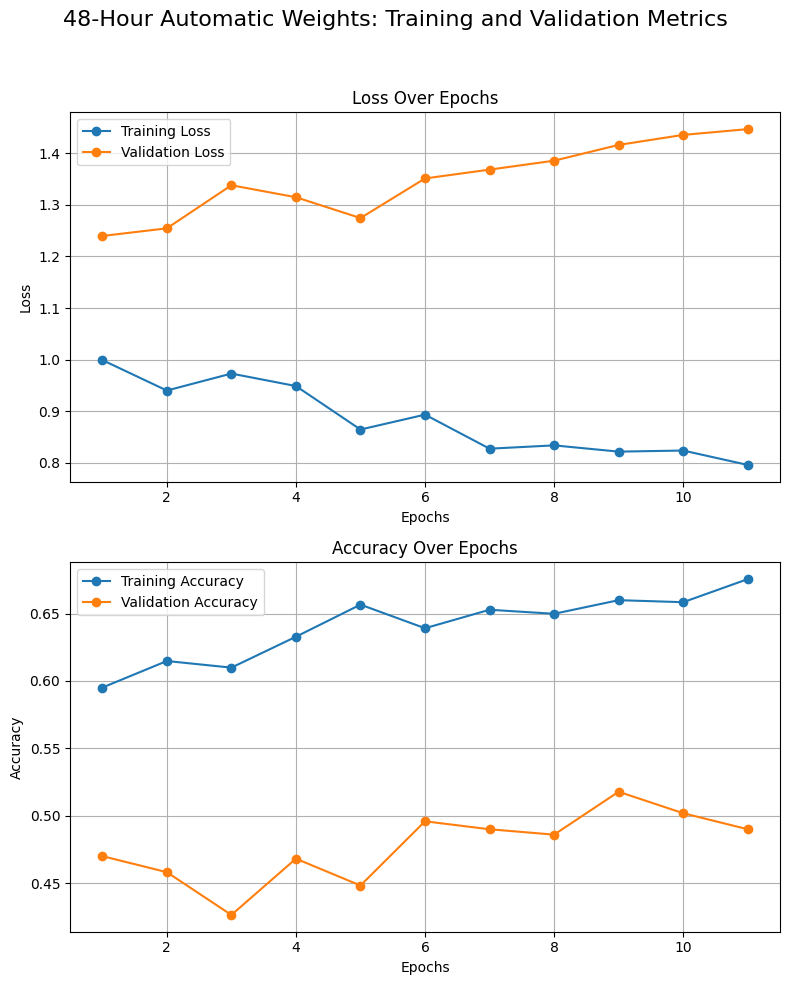

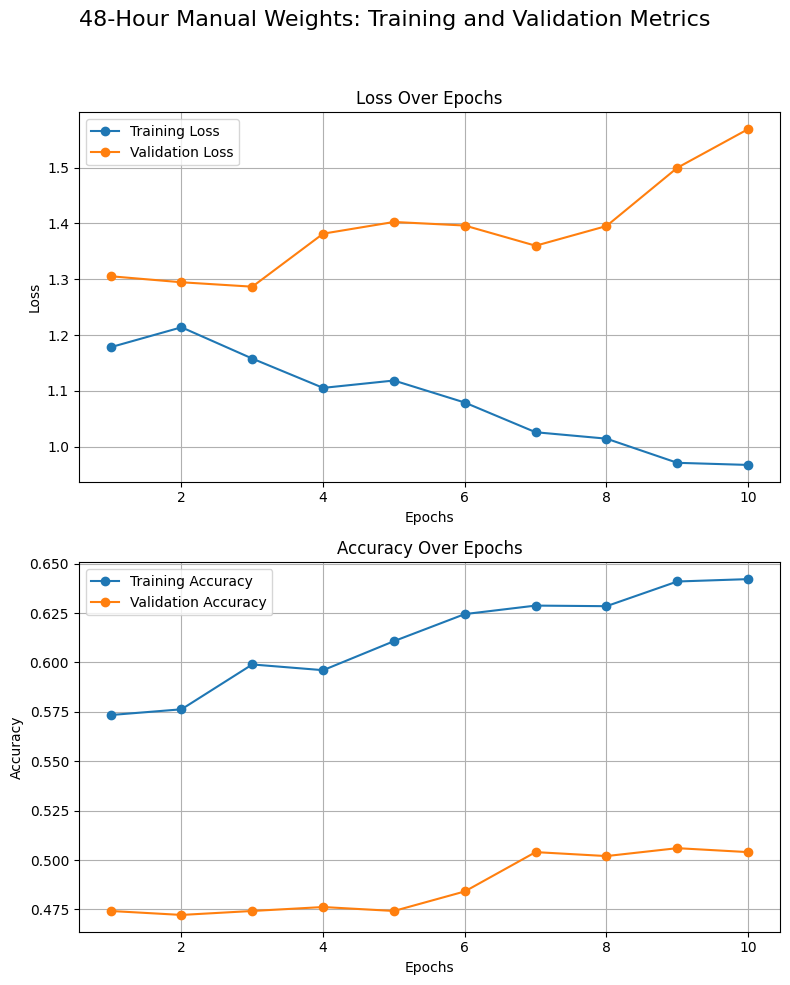

In [13]:
history_48_auto = {
    "accuracy": [
        0.5951,
        0.6148,
        0.6099,
        0.6328,
        0.6566,
        0.6391,
        0.6528,
        0.6498,
        0.6599,
        0.6584,
        0.6755,
    ],
    "val_accuracy": [
        0.4702,
        0.4583,
        0.4266,
        0.4683,
        0.4484,
        0.4960,
        0.4901,
        0.4861,
        0.5179,
        0.5020,
        0.4901,
    ],
    "loss": [
        0.9992,
        0.9401,
        0.9730,
        0.9488,
        0.8645,
        0.8934,
        0.8274,
        0.8338,
        0.8217,
        0.8238,
        0.7959,
    ],
    "val_loss": [
        1.2397,
        1.2545,
        1.3380,
        1.3148,
        1.2744,
        1.3512,
        1.3683,
        1.3856,
        1.4162,
        1.4356,
        1.4468,
    ],
}

history_48_manual = {
    "accuracy": [
        0.5734,
        0.5763,
        0.5990,
        0.5961,
        0.6108,
        0.6245,
        0.6288,
        0.6285,
        0.6410,
        0.6422,
    ],
    "val_accuracy": [
        0.4742,
        0.4722,
        0.4742,
        0.4762,
        0.4742,
        0.4841,
        0.5040,
        0.5020,
        0.5060,
        0.5040,
    ],
    "loss": [
        1.1782,
        1.2139,
        1.1578,
        1.1053,
        1.1185,
        1.0790,
        1.0258,
        1.0143,
        0.9710,
        0.9672,
    ],
    "val_loss": [
        1.3054,
        1.2946,
        1.2867,
        1.3817,
        1.4027,
        1.3963,
        1.3601,
        1.3954,
        1.4998,
        1.5691,
    ],
}

# Plot for 48-Hour Automatic Weights
plot_training_history(
    history_48_auto, "48-Hour Automatic Weights: Training and Validation Metrics"
)

# Plot for 48-Hour Manual Weights
plot_training_history(
    history_48_manual, "48-Hour Manual Weights: Training and Validation Metrics"
)

The accuracy and loss plots tell us a lot about how well our models are learning.

**Accuracy:**

- **Automatic:** The model gets better at predicting rainfall over time, both on the data it trained on (training set) and new data it hasn't seen before (validation set).
- **Manual:** It also improves, but not as much. It seems to struggle a bit more with new data.

**Loss:**

- **Automatic:** The model's mistakes get smaller and smaller, both on the training and validation data.
- **Manual:** It also improves, but it's a bit more bumpy. The validation loss even goes up a little at the end, which might mean it's overfitting.
So, what does this mean?

The model with automatic weight updates is the clear winner. It learns faster and more accurately, and it's better at handling new, unseen rainfall data. This suggests that letting the computer figure out the best way to adjust the model's settings (weights) is more effective than trying to do it manually.

## 6. 72-Hour Window Hybrid Model

Since our objective is to predict outcomes based on both meteorological and satellite image data, we are building a **Hybrid Model** that takes in the past **72-hour input**, and predicts the rainfall category for the **next-to-next-to-next day**. We need it to efficiently integrate spatiotemporal data into a unified architecture. Here's how we approach the design:

### 6.1 Model Architecture

---

### **Key Components of the Model**

#### **Input Layers**
- The model consists of **two input layers**:
  - One for **meteorological data**: 72-hour time-series with 10 features.
  - One for **cloud image sequences**: 24 images per sequence, each of size 64x64x1.

---

#### **Architecture**
1. **ConvLSTM for Cloud Data**  
   - Extracts spatial and temporal features from the satellite image sequences.
   - Two **ConvLSTM2D** layers with dropout for regularization to capture spatiotemporal patterns.
   - A **TimeDistributed Flatten layer** to reduce spatial dimensions, followed by an **LSTM layer** for summarizing temporal features.
   - Batch normalization stabilizes the training process.

2. **LSTM with Attention for Meteorological Data**  
   - Two **LSTM layers** are used to process meteorological time-series data, with dropout to mitigate overfitting.
   - An **attention mechanism** highlights the most critical time steps, improving the model's focus on key temporal patterns.
   - A final **LSTM layer** summarizes the attention-weighted features into a fixed-size representation.
   - Batch normalization is applied to maintain stability.

3. **Feature Combination**  
   - Features from both meteorological and cloud data streams are **concatenated** to create a unified representation.
   - Dense layers refine these combined features, with additional dropout layers for regularization.

---

#### **Output Layer**
- The model includes a **Dense layer** with a softmax activation function to classify data into the target categories.
- It produces a **single prediction** for the input, tailored to the respective time window.

---

### **Implementation Details**
- The model is compiled with the **Adam optimizer**, a learning rate of `0.0001`, and categorical crossentropy as the loss function.
- Metrics include accuracy to evaluate performance.


In [14]:
def hybrid_model_optimized_72(num_classes):
    """
    Hybrid model combining ConvLSTM for cloud image sequences and LSTM for meteorological data.
    """
    # Input for meteorological data
    meteo_input = Input(shape=(72, 10), name="meteo_input")

    # Input for cloud image data
    cloud_input = Input(shape=(24, 64, 64, 1), name="cloud_input")

    # --- ConvLSTM for Cloud Data ---
    def feature_extractor_images(input_layer):
        x = ConvLSTM2D(
            filters=8, kernel_size=(3, 3), padding="same", return_sequences=True
        )(input_layer)
        x = Dropout(0.25)(x)

        x = ConvLSTM2D(
            filters=16, kernel_size=(3, 3), padding="same", return_sequences=True
        )(x)
        x = Dropout(0.25)(x)

        x = TimeDistributed(Flatten())(x)
        x = LSTM(64, return_sequences=False)(x)
        x = BatchNormalization()(x)
        return x

    # --- LSTM with Attention for Meteorological Data ---
    def feature_extractor_meteo(input_layer):
        x = LSTM(128, return_sequences=True)(input_layer)
        x = Dropout(0.25)(x)

        x = LSTM(64, return_sequences=True)(x)
        x = Dropout(0.25)(x)

        # Adding attention over time steps
        attention = Attention()([x, x])
        x = LSTM(64, return_sequences=False)(attention)
        x = BatchNormalization()(x)
        return x

    # Extract features from inputs
    cloud_features = feature_extractor_images(cloud_input)
    meteo_features = feature_extractor_meteo(meteo_input)

    # --- Combine Features ---
    combined_features = Concatenate()([meteo_features, cloud_features])

    # --- Decoder Layers ---
    x = Dense(128, activation="relu")(combined_features)
    x = Dropout(0.25)(x)

    x = Dense(64, activation="relu")(x)
    x = Dropout(0.25)(x)

    # Output layer
    output = Dense(num_classes, activation="softmax", name="output")(x)

    # Define model
    model = Model(inputs=[cloud_input, meteo_input], outputs=output)

    return model


# Instantiate the model
num_classes = 4
# Compile the model
optimizer = Adam(learning_rate=0.0001)

model_automatic_weights_72 = hybrid_model_optimized_72(num_classes)

model_automatic_weights_72.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

# Display model summary
model_automatic_weights_72.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ meteo_input         │ (None, 72, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cloud_input         │ (None, 24, 64,    │          0 │ -                 │
│ (InputLayer)        │ 64, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_17 (LSTM)      │ (None, 72, 128)   │     71,168 │ meteo_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_8       │ (None, 24, 64,    │      2,624 │ cloud_input[0][0] │
│ (ConvLSTM2D)        │ 64, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 72, 128)   │          0 │ lstm_17[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 24, 64,    │          0 │ conv_lstm2d_8[0]… │
│ (Dropout)           │ 64, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_18 (LSTM)      │ (None, 72, 64)    │     49,408 │ dropout_26[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_9       │ (None, 24, 64,    │     13,888 │ dropout_24[0][0]  │
│ (ConvLSTM2D)        │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 72, 64)    │          0 │ lstm_18[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 24, 64,    │          0 │ conv_lstm2d_9[0]… │
│ (Dropout)           │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_4         │ (None, 72, 64)    │          0 │ dropout_27[0][0], │
│ (Attention)         │                   │            │ dropout_27[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, 24, 65536) │          0 │ dropout_25[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_19 (LSTM)      │ (None, 64)        │     33,024 │ attention_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_16 (LSTM)      │ (None, 64)        │ 16,793,856 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ lstm_19[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ lstm_16[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 128)       │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │     16,512 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 16,989,508 (64.81 MB)

 Trainable params: 16,989,252 (64.81 MB)

 Non-trainable params: 256 (1.00 KB)

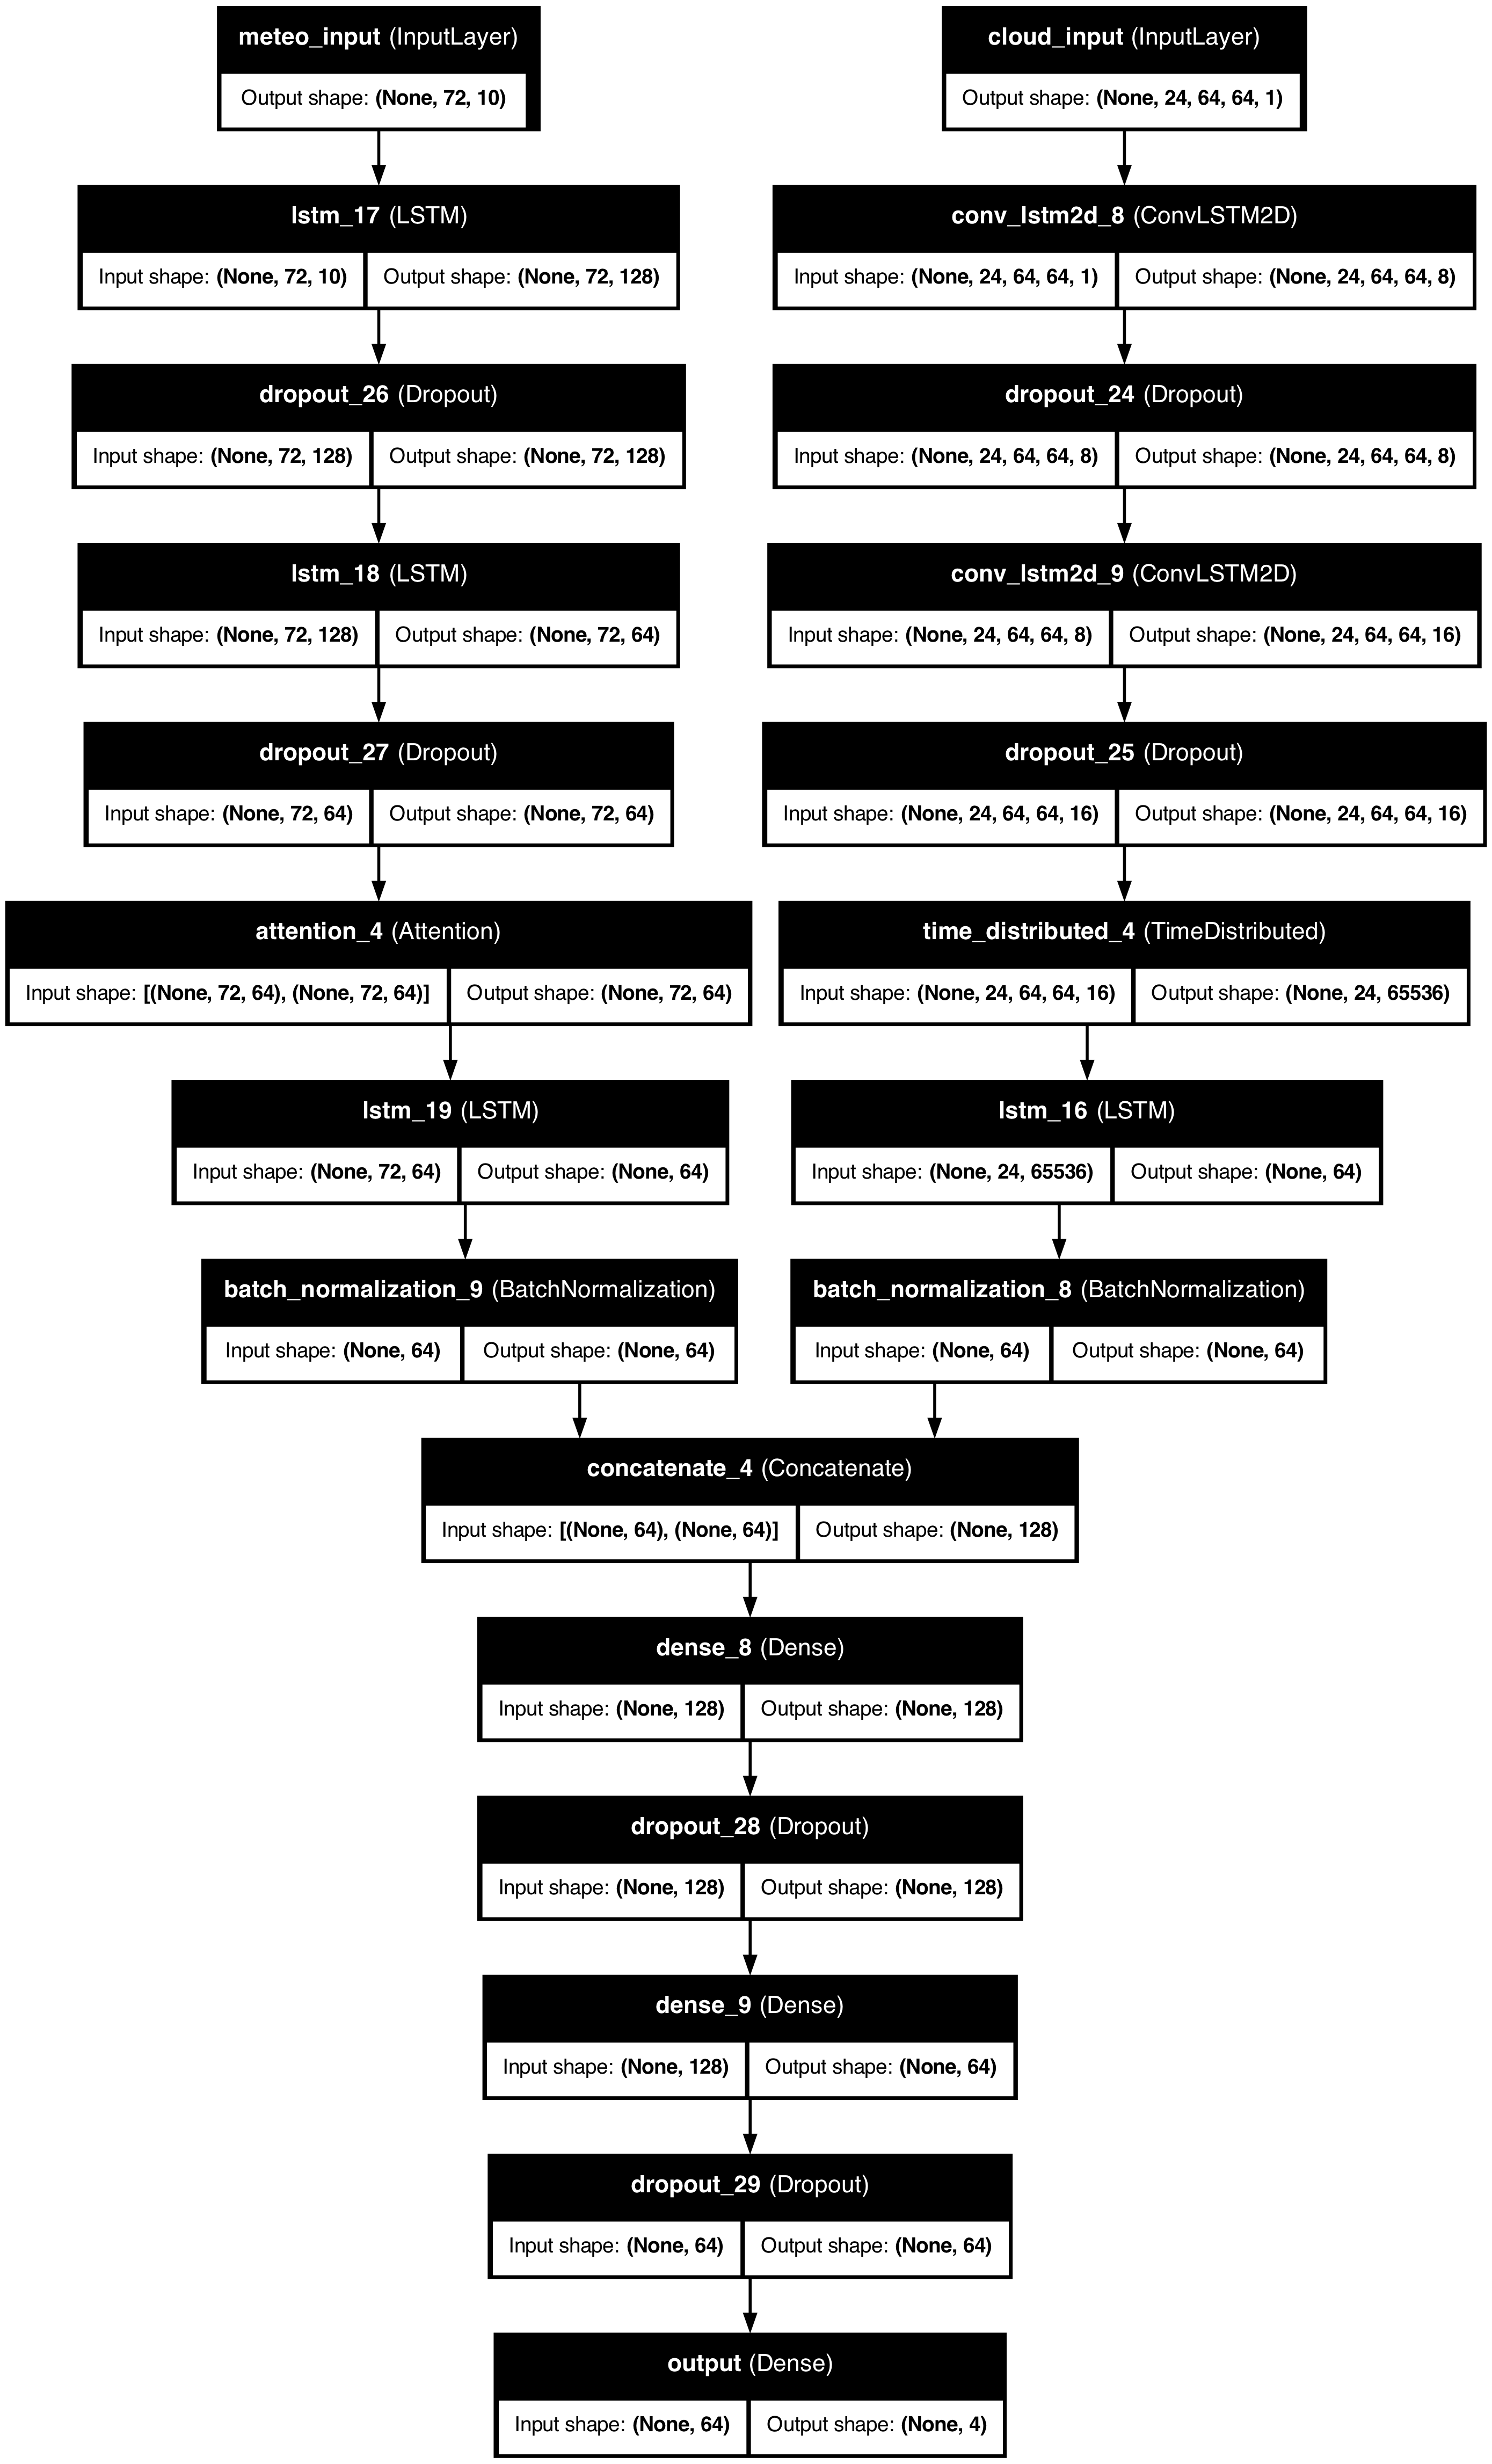

In [15]:
from tensorflow.keras.utils import plot_model

# Assuming you have your model instantiated as 'model'
plot_model(model_automatic_weights_72, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

As you can see, our model is a hybrid, combining two powerful tools:

1. Meteorological Data Branch:
- **LSTM Layers:** These are like time machines, understanding how weather patterns change over time. They're processing 72 hours of historical weather data.
- **Attention Mechanism:** This is the model's superpower, focusing on the most important parts of the past weather to make better predictions.

2. Cloud Image Data Branch:
- **ConvLSTM Layers:** These layers are like image experts, learning to recognize patterns in cloud formations and how they change over time.
- **TimeDistributed Flatten:** This layer prepares the cloud image data for the next step.
- **LSTM Layer:** This layer processes the sequence of cloud images, capturing the temporal dynamics.

**The Fusion:**

Concatenation: Both branches combine their insights into a single, powerful representation.

**The Decoder:**

Dense Layers: These layers process the combined information, reducing complexity and learning important patterns.
Dropout: This prevents the model from becoming too reliant on specific patterns, making it more adaptable.

**The Output:**

Dense Layer: This layer makes the final prediction, assigning probabilities to different weather classes

### 6.2 Loading the Models

We have already built a 72-Hour Model with automatic and manual class weights. Why don't we load both the models, and evaluate how they are performing.

In [16]:
weights_path = "72_automatic_weights/72_window_hybrid_model_automatic_weights_additional_epoch_10.h5"

# Load the weights
model_automatic_weights_72.load_weights(weights_path)

print("Weights successfully loaded!")

Weights successfully loaded!


In [17]:
model_manual_weights_72 = hybrid_model_optimized_72(num_classes)

model_manual_weights_72.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

weights_path = (
    "72_manual_weights/72_window_hybrid_model_manual_weights_additional_epoch_10.h5"
)

# Load the weights
model_manual_weights_72.load_weights(weights_path)

print("Weights successfully loaded!")

Weights successfully loaded!


### 6.3 Training and Validation Curves

Now, Let's evaluate the performance of the 72-Hour Model with automatic weights and manual weights, and compare their results.

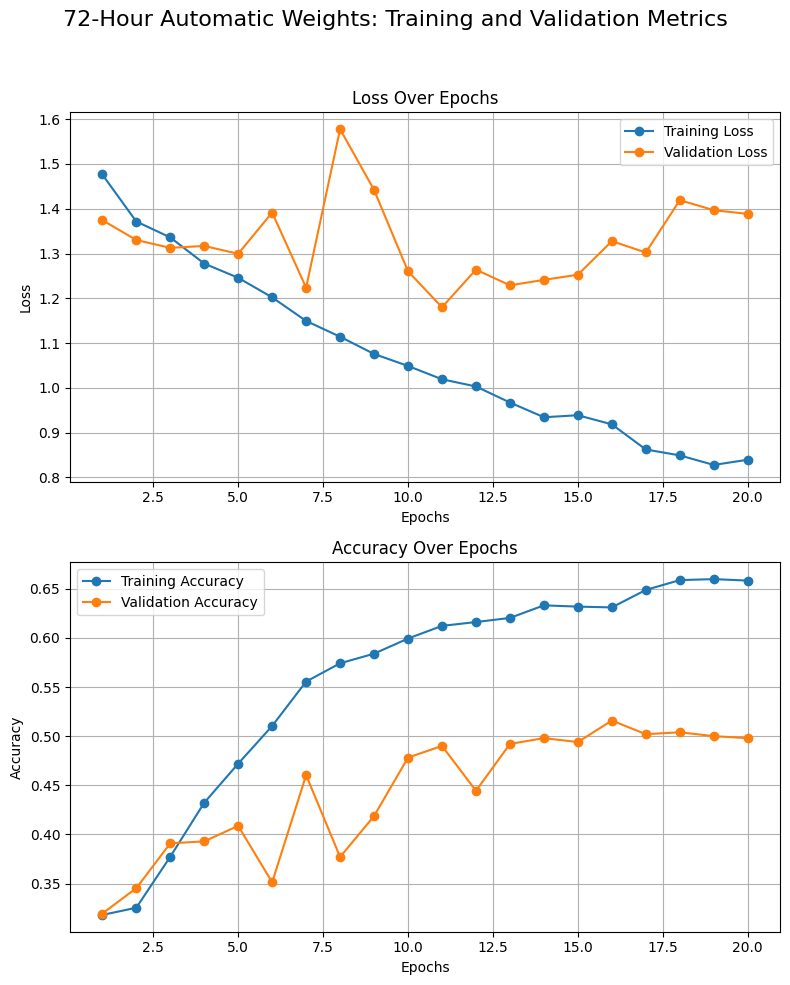

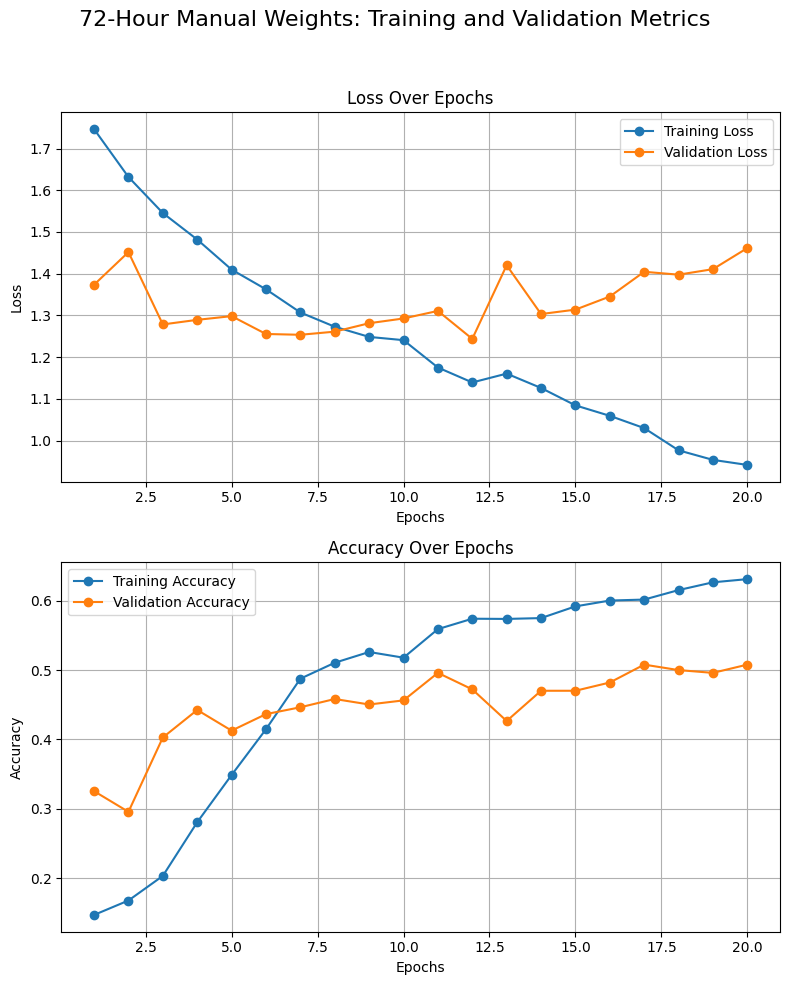

In [18]:
history_72_auto = {
    "accuracy": [
        0.3180,
        0.3253,
        0.3772,
        0.4322,
        0.4720,
        0.5104,
        0.5556,
        0.5742,
        0.5840,
        0.5994,
        0.6123,
        0.6162,
        0.6204,
        0.6332,
        0.6319,
        0.6311,
        0.6489,
        0.6589,
        0.6599,
        0.6584,
    ],
    "val_accuracy": [
        0.3194,
        0.3452,
        0.3909,
        0.3929,
        0.4087,
        0.3512,
        0.4603,
        0.3770,
        0.4187,
        0.4782,
        0.4901,
        0.4444,
        0.4921,
        0.4980,
        0.4940,
        0.5159,
        0.5020,
        0.5040,
        0.5000,
        0.4980,
    ],
    "loss": [
        1.4765,
        1.3715,
        1.3360,
        1.2776,
        1.2458,
        1.2021,
        1.1494,
        1.1142,
        1.0757,
        1.0489,
        1.0192,
        1.0031,
        0.9673,
        0.9344,
        0.9389,
        0.9185,
        0.8624,
        0.8492,
        0.8279,
        0.8395,
    ],
    "val_loss": [
        1.3746,
        1.3302,
        1.3127,
        1.3169,
        1.2994,
        1.3915,
        1.2238,
        1.5778,
        1.4420,
        1.2603,
        1.1800,
        1.2640,
        1.2290,
        1.2411,
        1.2527,
        1.3276,
        1.3023,
        1.4191,
        1.3968,
        1.3885,
    ],
}

history_72_manual = {
    "accuracy": [
        0.1469,
        0.1677,
        0.2032,
        0.2806,
        0.3487,
        0.4147,
        0.4876,
        0.5106,
        0.5261,
        0.5179,
        0.5591,
        0.5741,
        0.5738,
        0.5750,
        0.5919,
        0.6003,
        0.6017,
        0.6154,
        0.6266,
        0.6312,
    ],
    "val_accuracy": [
        0.3254,
        0.2956,
        0.4028,
        0.4425,
        0.4127,
        0.4365,
        0.4464,
        0.4583,
        0.4504,
        0.4563,
        0.4960,
        0.4722,
        0.4266,
        0.4702,
        0.4702,
        0.4821,
        0.5079,
        0.5000,
        0.4960,
        0.5079,
    ],
    "loss": [
        1.7466,
        1.6318,
        1.5455,
        1.4819,
        1.4099,
        1.3626,
        1.3071,
        1.2729,
        1.2485,
        1.2407,
        1.1751,
        1.1393,
        1.1605,
        1.1261,
        1.0844,
        1.0593,
        1.0299,
        0.9766,
        0.9537,
        0.9416,
    ],
    "val_loss": [
        1.3736,
        1.4518,
        1.2784,
        1.2894,
        1.2983,
        1.2555,
        1.2536,
        1.2611,
        1.2813,
        1.2927,
        1.3108,
        1.2438,
        1.4202,
        1.3033,
        1.3139,
        1.3453,
        1.4046,
        1.3977,
        1.4109,
        1.4615,
    ],
}


# Plot for 72-Hour Automatic Weights
plot_training_history(
    history_72_auto, "72-Hour Automatic Weights: Training and Validation Metrics"
)

# Plot for 72-Hour Manual Weights
plot_training_history(
    history_72_manual, "72-Hour Manual Weights: Training and Validation Metrics"
)

Looking at the accuracy and loss curves, we can see a similar trend to the 24 and 48-hour models:

**Accuracy:**

- Automatic Weights: This model shows a steady improvement in accuracy, both on the training and validation sets. It reaches a peak validation accuracy of around 0.51, indicating strong generalization to unseen data.
- Manual Weights: While it also improves, its performance lags behind the automatic model. It struggles to maintain a consistent upward trend in validation accuracy, suggesting potential overfitting.

**Loss:**

- Automatic Weights: The loss decreases steadily for both training and validation sets, demonstrating effective learning.
- Manual Weights: The loss also decreases, but it's more volatile, especially in the validation loss. This suggests that the model might be overfitting to the training data.
Conclusion:

Once again, the automatic weight update strategy proves superior. The 72-hour automatic model exhibits higher accuracy and more stable loss, indicating better learning and generalization. 

## 7. Model Evaluation


<div style="text-align: center;">
    <img src="images\metrics.jpg" width="800" />
</div>


#### Why Do We Evaluate Models?
Imagine you're training a weather prediction model like a detective solving a mystery. Just like a detective doesn't just solve a case but reviews the evidence, we need to check how well our model performs.

#### So, what is our strategy to evaluate our models? 
**1. Prediction Accuracy**

Model performance evaluation is a systematic approach to assessing predictive accuracy, precision, and recall, providing a comprehensive understanding of how well a machine learning model captures and predicts target events.

By analyzing key metrics like true positives, false positives, and overall prediction rates, we gain insights into the model's reliability and potential areas for improvement.

**2. Confusion Matrix: The Evidence Board**

Each matrix represents the model's prediction results compared to actual labels:
- Rows correspond to true classes.
- Columns correspond to predicted classes.
- The diagonal indicates correct predictions.
- Off-diagonal elements represent misclassifications.

**3. Sample Investigation**
- We will analyze a "High Rain" prediction by reviewing the model's decision-making process, focusing on key input features and atmospheric patterns that influenced the outcome. - We'll present relevant meteorological data, including temperature, humidity, and pressure information, alongside cloud imagery from satellite and radar that highlights significant formations associated with heavy rain. 
- Additionally, we'll display the model's confidence through probability distributions and compare its predictions with traditional weather forecasts. 


**Exciting Part: Transparency!**

We're not just saying "trust me" - we're showing exactly how our model thinks and makes decisions.

In [19]:
from sklearn.metrics import confusion_matrix, classification_report


def evaluate_model_with_sample(
    model, generator, class_names, sample_class_index=0, num_images_per_window=None
):
    """
    Evaluate the model and display a sample input and its prediction, with dynamic image grid layout.

    Args:
        model: The trained model.
        generator: Data generator for evaluation.
        class_names: List of class names.
        sample_class_index: Class index for the sample to display (default: 0 for "High Rain").
        num_images_per_window: Number of images per window size (dictionary of window size to image count).
    """
    # Step 1: Predict on the validation data
    y_pred_probs = model.predict(generator)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = []
    for i in range(len(generator)):
        inputs, labels = generator[i][:2]  # Extract batch labels
        y_true.append(np.argmax(labels, axis=1))

    # Concatenate batches
    y_true = np.concatenate(y_true)

    # Step 2: Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Step 3: Generate classification report
    report = classification_report(y_true, y_pred, target_names=class_names)
    print("\nClassification Report:\n", report)

    # Step 4: Visualize confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Step 5: Display a sample input and its prediction
    print("\n=== Sample Input and Prediction ===")
    for i in range(len(generator)):
        inputs, labels = generator[i][:2]  # Fetch a batch
        batch_indices = np.where(np.argmax(labels, axis=1) == sample_class_index)[0]
        if len(batch_indices) > 0:
            sample_index = batch_indices[0]  # Take the first matching sample
            break
    else:
        print(
            f"No samples found for class index {sample_class_index} ({class_names[sample_class_index]})."
        )
        return

    # Extract the sample data
    sample_meteo = inputs["meteo_input"][sample_index]
    sample_images = inputs["cloud_input"][sample_index]
    true_label = class_names[np.argmax(labels[sample_index])]
    predicted_probs = y_pred_probs[i * generator.batch_size + sample_index]
    predicted_label = class_names[np.argmax(predicted_probs)]

    # Display meteorological data
    print(f"\nTrue Label: {true_label}")
    print(f"Predicted Label: {predicted_label}")
    print(f"Predicted Probabilities: {predicted_probs}")

    meteo_features = [f"Feature {i}" for i in range(sample_meteo.shape[1])]
    meteo_df = pd.DataFrame(sample_meteo, columns=meteo_features)
    print("\nMeteorological Data (Sample Input):")
    display(meteo_df)

    # Display cloud images with dynamic layout
    num_images = sample_images.shape[0]
    rows, cols = {8: (2, 4), 16: (4, 4), 24: (6, 4)}.get(
        num_images, (1, num_images)
    )  # Default to 1 row if undefined

    print("\nCloud Images (Sample Input):")
    plt.figure(figsize=(16, 12))
    for img_idx in range(num_images):  # Loop through the image sequence
        plt.subplot(rows, cols, img_idx + 1)
        plt.imshow(sample_images[img_idx].squeeze(), cmap="gray")
        plt.axis("off")
        plt.title(f"Image {img_idx + 1}")
    plt.tight_layout()
    plt.show()


# Class names
class_names = ["High Rain", "Less Rain", "Medium Rain", "No Rain"]

### 7.1. 24-Hour Model (Automatic Class Weights)

=== 24-Hour Model (automatic class weights) Results: === 
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 298ms/step

Classification Report:
               precision    recall  f1-score   support

   High Rain       0.46      0.51      0.48       126
   Less Rain       0.45      0.21      0.28       126
 Medium Rain       0.41      0.40      0.41       126
     No Rain       0.55      0.80      0.65       126

    accuracy                           0.48       504
   macro avg       0.47      0.48      0.46       504
weighted avg       0.47      0.48      0.46       504



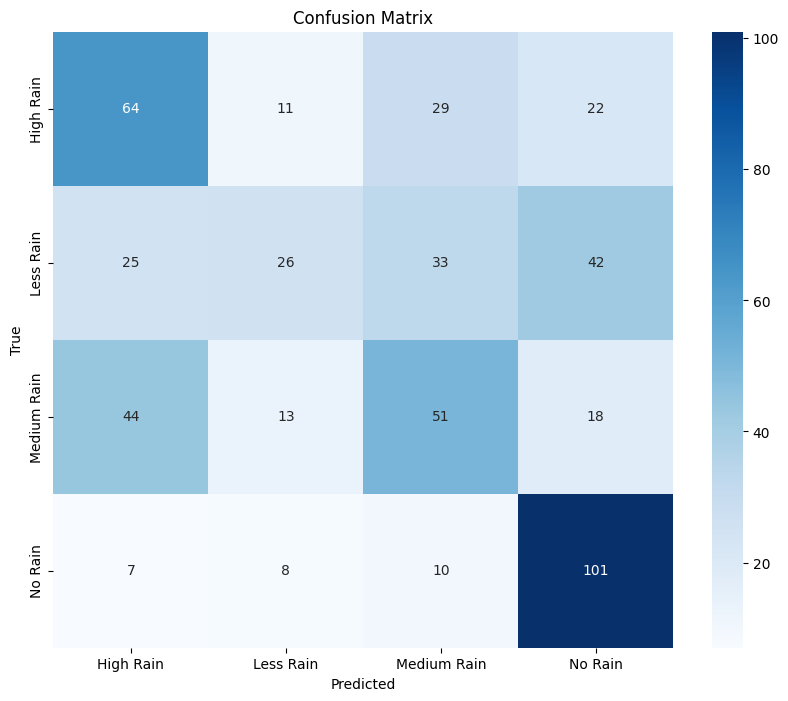


=== Sample Input and Prediction ===

True Label: High Rain
Predicted Label: High Rain
Predicted Probabilities: [0.44693658 0.05858582 0.36061484 0.13386278]

Meteorological Data (Sample Input):


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,68.0,1015.299988,27.0,18.0,1014.599976,991.700012,2600.0,290.0,10.0,0.0
1,65.0,1015.000000,28.0,18.0,1014.200012,991.299988,2800.0,290.0,6.0,0.0
2,74.0,1015.000000,27.0,20.0,1014.200012,991.299988,3000.0,260.0,5.0,0.0
3,77.0,1014.099976,28.0,22.0,1013.200012,990.299988,2100.0,220.0,3.0,2700.0
4,81.0,1013.599976,28.0,23.0,1012.900024,990.000000,1700.0,230.0,5.0,2300.0
5,68.0,1012.599976,29.0,20.0,1011.900024,989.000000,1700.0,250.0,9.0,2500.0
6,71.0,1012.500000,27.0,19.0,1011.900024,989.000000,1900.0,240.0,9.0,2800.0
7,71.0,1012.599976,27.0,19.0,1011.900024,989.000000,2100.0,250.0,6.0,0.0
8,71.0,1012.799988,26.0,18.0,1011.900024,989.000000,1900.0,220.0,9.0,0.0
9,68.0,1013.200012,26.0,17.0,1012.200012,989.299988,2300.0,230.0,5.0,0.0



Cloud Images (Sample Input):


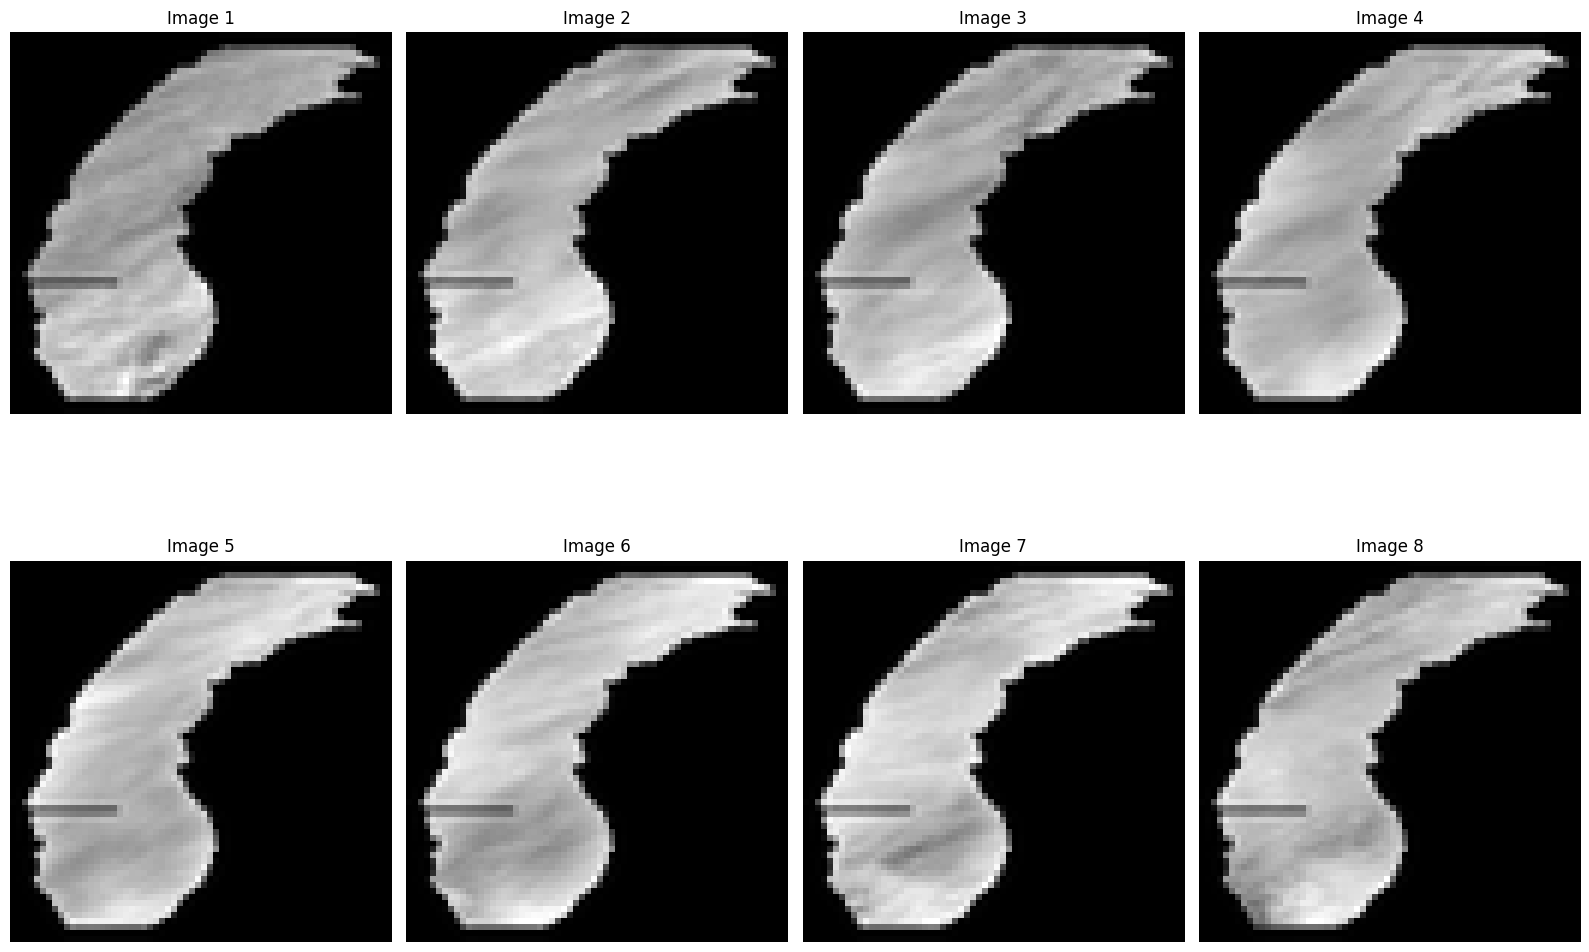

In [20]:
# Evaluate all models
print("=== 24-Hour Model (automatic class weights) Results: === ")
evaluate_model_with_sample(model_automatic_weights_24, val_generator_24, class_names, 0)

**Sample Prediction:** The model correctly classified a "High Rain" sample with a predicted probability of 44.69%, though it showed some uncertainty with 36.06% for "Medium Rain." This highlights moderate confidence in its prediction.

**Performance:**

The 24-hour rainfall prediction model achieved an overall accuracy of 48% and a macro-average F1-score of 46%, indicating moderate performance. Among the four categories, "No Rain" showed the strongest results with a recall of 80% and an F1-score of 65%, reflecting the model’s ability to identify most non-rain cases accurately. However, this dominance suggests a prediction bias toward "No Rain."

In contrast, "Less Rain" was the weakest-performing category, with a low recall of 21% and an F1-score of 28%, highlighting significant difficulty in distinguishing this class. Predictions for "High Rain" and "Medium Rain" were more balanced, with F1-scores of 48% and 41%, respectively, but remain suboptimal, indicating overlapping patterns between these categories.

These results suggest that the model struggles to differentiate between varying rainfall intensities, favoring simpler classifications like "No Rain." Improvements in class balance and feature representation are essential to enhance predictive performance.

### 7.2 24-Hour Model (Manual Class Weights)

=== 24-Hour Model (manual class weights) Results: ===
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 302ms/step

Classification Report:
               precision    recall  f1-score   support

   High Rain       0.52      0.36      0.42       126
   Less Rain       0.34      0.44      0.39       126
 Medium Rain       0.44      0.37      0.41       126
     No Rain       0.60      0.71      0.65       126

    accuracy                           0.47       504
   macro avg       0.48      0.47      0.47       504
weighted avg       0.48      0.47      0.47       504



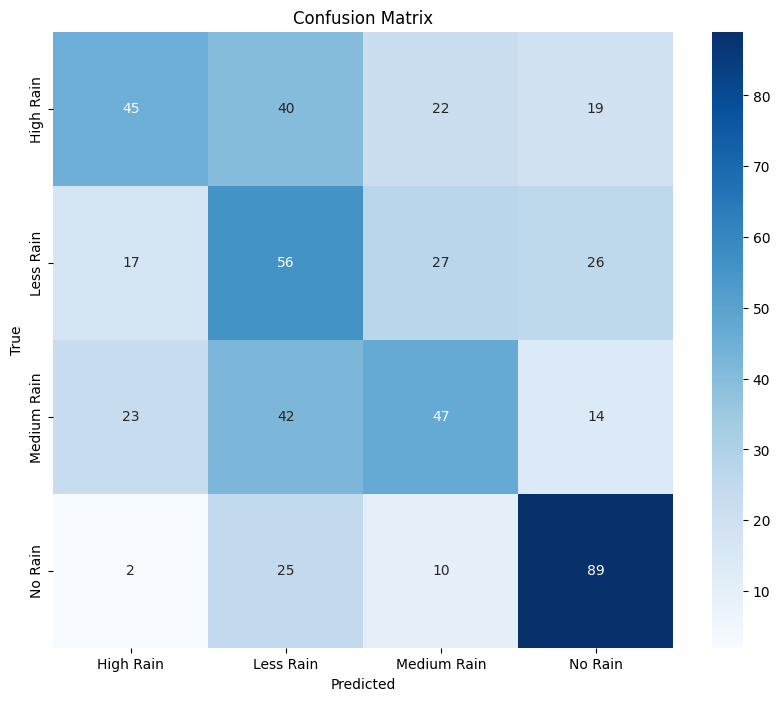


=== Sample Input and Prediction ===

True Label: High Rain
Predicted Label: No Rain
Predicted Probabilities: [0.07675406 0.1788733  0.36871535 0.37565738]

Meteorological Data (Sample Input):


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,68.0,1015.299988,27.0,18.0,1014.599976,991.700012,2600.0,290.0,10.0,0.0
1,65.0,1015.000000,28.0,18.0,1014.200012,991.299988,2800.0,290.0,6.0,0.0
2,74.0,1015.000000,27.0,20.0,1014.200012,991.299988,3000.0,260.0,5.0,0.0
3,77.0,1014.099976,28.0,22.0,1013.200012,990.299988,2100.0,220.0,3.0,2700.0
4,81.0,1013.599976,28.0,23.0,1012.900024,990.000000,1700.0,230.0,5.0,2300.0
5,68.0,1012.599976,29.0,20.0,1011.900024,989.000000,1700.0,250.0,9.0,2500.0
6,71.0,1012.500000,27.0,19.0,1011.900024,989.000000,1900.0,240.0,9.0,2800.0
7,71.0,1012.599976,27.0,19.0,1011.900024,989.000000,2100.0,250.0,6.0,0.0
8,71.0,1012.799988,26.0,18.0,1011.900024,989.000000,1900.0,220.0,9.0,0.0
9,68.0,1013.200012,26.0,17.0,1012.200012,989.299988,2300.0,230.0,5.0,0.0



Cloud Images (Sample Input):


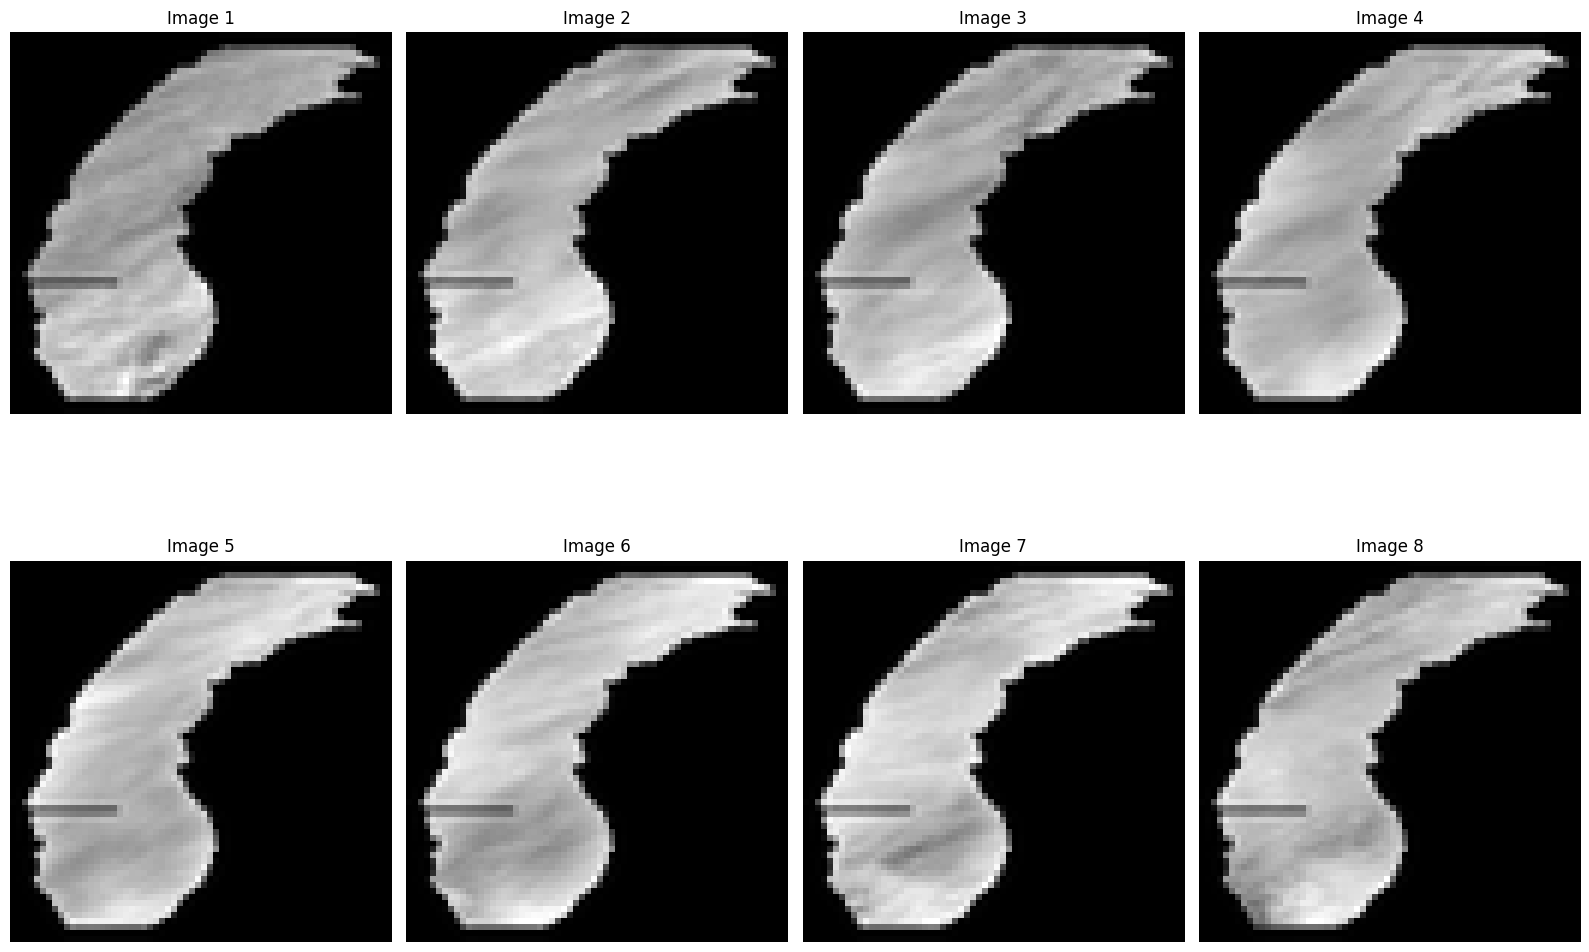

In [21]:
print("=== 24-Hour Model (manual class weights) Results: ===")
evaluate_model_with_sample(model_manual_weights_24, val_generator_24, class_names, 0)

**Model Results:**

The automatic class weights approach achieved an accuracy of 48% and an F1-score of 46%, while the manual class weights method had slightly lower accuracy at 47% but an F1-score of 47%, indicating a shift in class performance.
- **High Rain:** Automatic weights performed better (F1-score 48%) with higher recall (51%) compared to manual weights (F1-score 42%, recall 36%).
- **Less Rain:** Manual weights improved recall significantly (44%) and achieved a better F1-score (39%) than automatic weights (21% recall, 28% F1-score).
- **No Rain:** Both models performed similarly, but automatic weights had higher recall (80%) compared to manual weights (71%).

Manual weights provided a more balanced performance across classes, while automatic weights excelled at extremes like "No Rain" and "High Rain."

**Sample Prediction:** 

The model misclassified a "High Rain" sample as "No Rain," with predicted probabilities of 37.57% for "No Rain" and 36.87% for "Medium Rain," indicating uncertainty and poor confidence in identifying the correct label.

### 7.3. 48-Hour Model (Automatic Class Weights)

=== 48-Hour Model (automatic class weights) Results: === 
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 559ms/step

Classification Report:
               precision    recall  f1-score   support

   High Rain       0.54      0.70      0.61       126
   Less Rain       0.38      0.30      0.34       126
 Medium Rain       0.47      0.41      0.44       126
     No Rain       0.60      0.62      0.61       126

    accuracy                           0.51       504
   macro avg       0.50      0.51      0.50       504
weighted avg       0.50      0.51      0.50       504



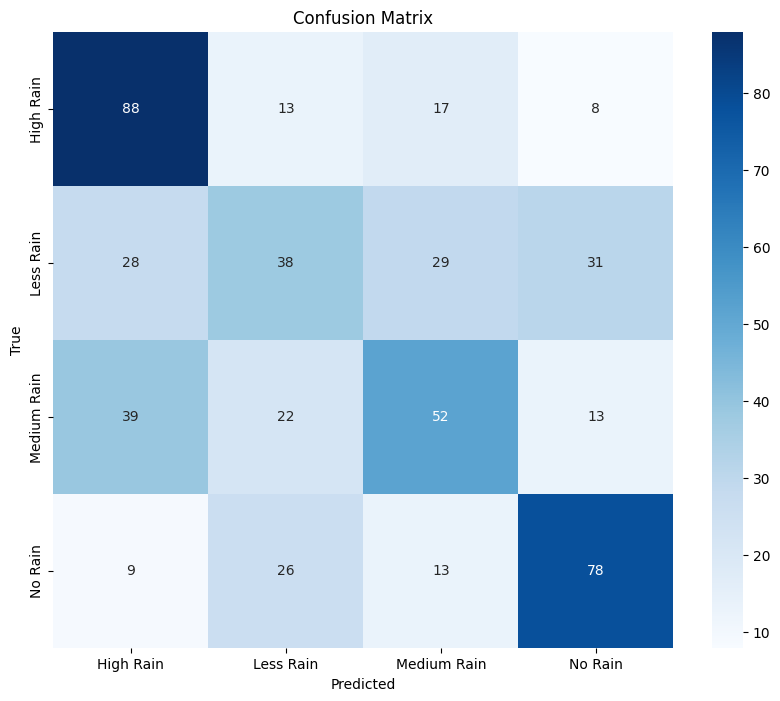


=== Sample Input and Prediction ===

True Label: High Rain
Predicted Label: High Rain
Predicted Probabilities: [0.9114119  0.04132771 0.03783174 0.00942866]

Meteorological Data (Sample Input):


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,66.0,31.0,1018.299988,1019.099976,21.0,2700.0,995.299988,3.0,160.0,0.0
1,68.0,30.0,1018.299988,1019.200012,21.0,2700.0,995.299988,5.0,0.0,0.0
2,68.0,31.0,1017.599976,1018.599976,22.0,2700.0,994.700012,8.0,190.0,0.0
3,69.0,32.0,1017.599976,1018.400024,23.0,2700.0,994.700012,9.0,190.0,0.0
4,68.0,31.0,1016.900024,1017.700012,22.0,2500.0,994.000000,8.0,200.0,0.0
5,68.0,31.0,1016.599976,1017.299988,22.0,2900.0,993.700012,7.0,210.0,0.0
6,72.0,31.0,1015.599976,1016.500000,23.0,2400.0,992.700012,6.0,0.0,0.0
7,60.0,29.0,1023.000000,1023.900024,17.0,0.0,1000.000000,10.0,240.0,0.0
8,62.0,28.0,1023.000000,1023.700012,17.0,0.0,1000.000000,11.0,250.0,0.0
9,65.0,28.0,1023.000000,1023.799988,18.0,0.0,1000.000000,6.0,240.0,0.0



Cloud Images (Sample Input):


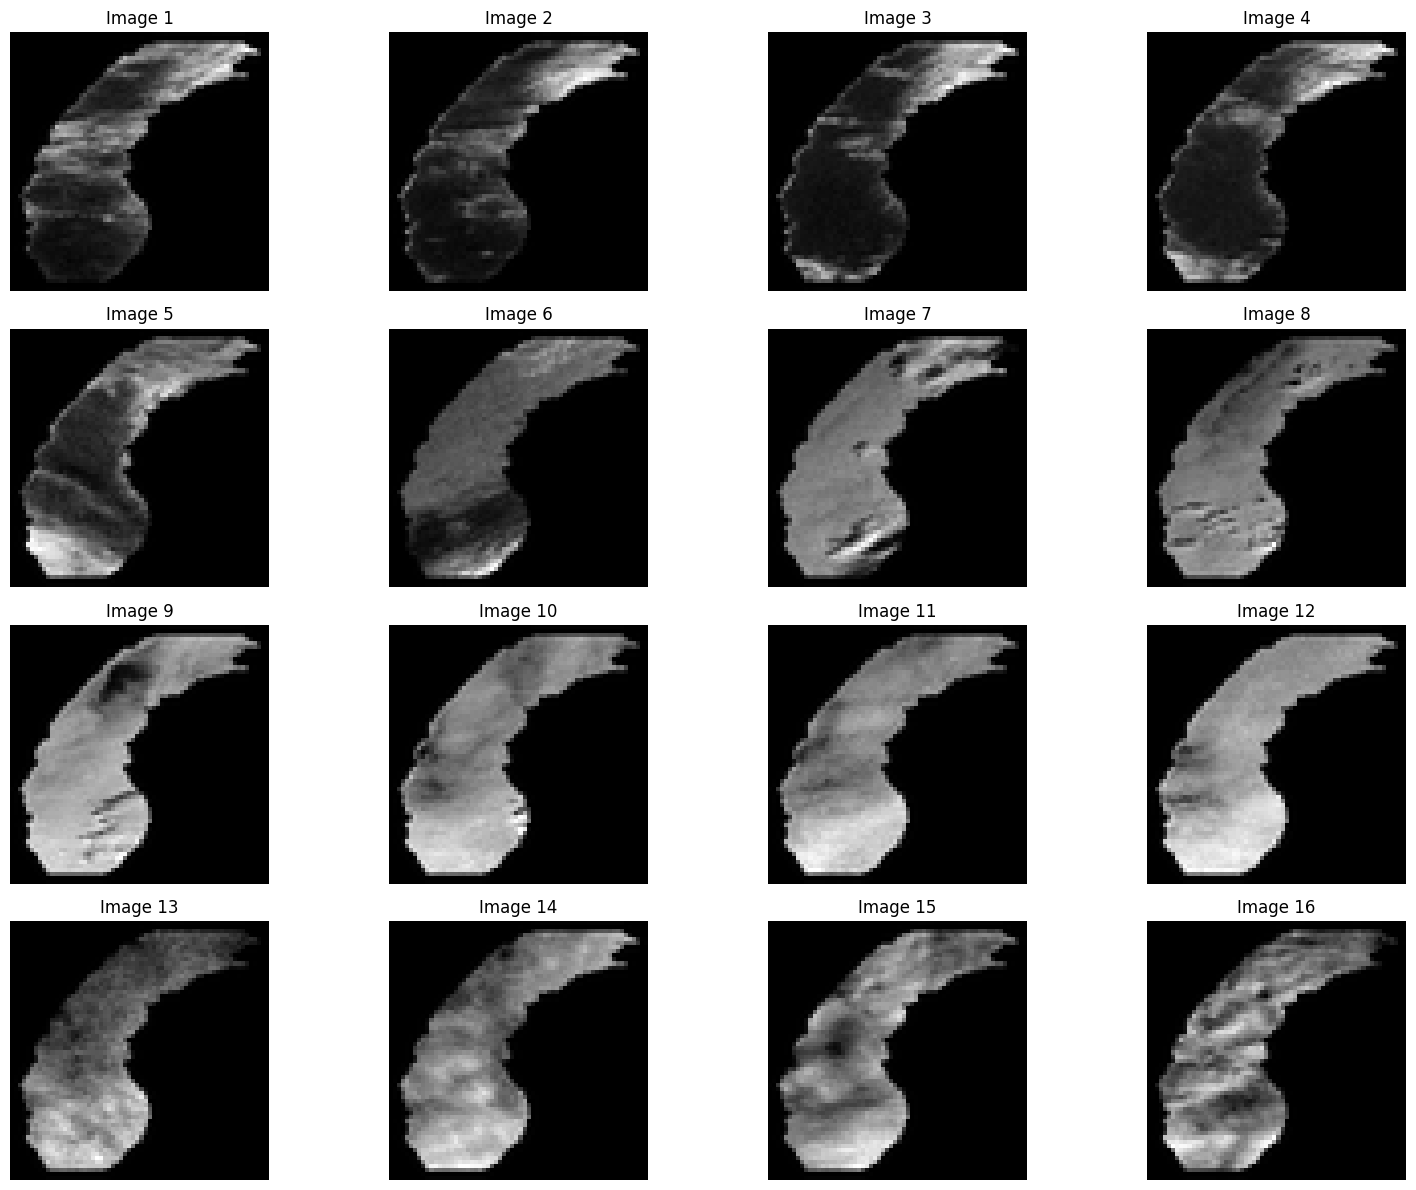

In [22]:
print("=== 48-Hour Model (automatic class weights) Results: === ")
evaluate_model_with_sample(model_automatic_weights_48, val_generator_48, class_names, 0)

#### Model Results

Our team’s 48-hour rainfall prediction model with automatic class weights achieved an accuracy of 51% and a macro-average F1-score of 50%, showing moderate improvement over the 24-hour model. The model performed best for "High Rain", achieving an F1-score of 61% with a recall of 70%, demonstrating its reliability in identifying heavy rainfall.

Performance for "No Rain" was also strong, with an F1-score of 61%. However, the model faced challenges with "Less Rain" (F1-score 34%) and showed moderate success for "Medium Rain" (F1-score 44%). These results reflect progress while highlighting areas for further refinement, particularly in distinguishing lighter rainfall categories.

#### Sample Prediction

As we move onto our sample prediction, our model correctly classified a "High Rain" sample with a predicted probability of 91.14%, demonstrating high confidence in the correct label. The probabilities for other classes—4.13% for "Less Rain," 3.78% for "Medium Rain," and 0.94% for "No Rain"—reflect the model's strong focus on the correct classification.

### 7.4 48-Hour Model (Manual Class Weights)

=== 48-Hour Model (manual class weights) Results: ===
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 566ms/step

Classification Report:
               precision    recall  f1-score   support

   High Rain       0.54      0.63      0.58       126
   Less Rain       0.40      0.34      0.37       126
 Medium Rain       0.43      0.40      0.41       126
     No Rain       0.58      0.63      0.60       126

    accuracy                           0.50       504
   macro avg       0.49      0.50      0.49       504
weighted avg       0.49      0.50      0.49       504



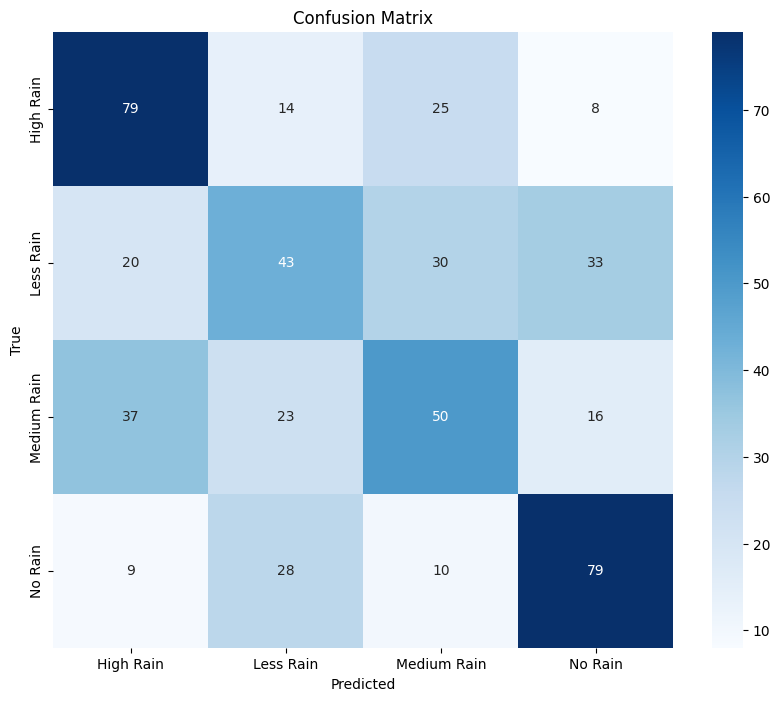


=== Sample Input and Prediction ===

True Label: High Rain
Predicted Label: High Rain
Predicted Probabilities: [0.928335   0.01163846 0.04730745 0.0127191 ]

Meteorological Data (Sample Input):


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,66.0,31.0,1018.299988,1019.099976,21.0,2700.0,995.299988,3.0,160.0,0.0
1,68.0,30.0,1018.299988,1019.200012,21.0,2700.0,995.299988,5.0,0.0,0.0
2,68.0,31.0,1017.599976,1018.599976,22.0,2700.0,994.700012,8.0,190.0,0.0
3,69.0,32.0,1017.599976,1018.400024,23.0,2700.0,994.700012,9.0,190.0,0.0
4,68.0,31.0,1016.900024,1017.700012,22.0,2500.0,994.000000,8.0,200.0,0.0
5,68.0,31.0,1016.599976,1017.299988,22.0,2900.0,993.700012,7.0,210.0,0.0
6,72.0,31.0,1015.599976,1016.500000,23.0,2400.0,992.700012,6.0,0.0,0.0
7,60.0,29.0,1023.000000,1023.900024,17.0,0.0,1000.000000,10.0,240.0,0.0
8,62.0,28.0,1023.000000,1023.700012,17.0,0.0,1000.000000,11.0,250.0,0.0
9,65.0,28.0,1023.000000,1023.799988,18.0,0.0,1000.000000,6.0,240.0,0.0



Cloud Images (Sample Input):


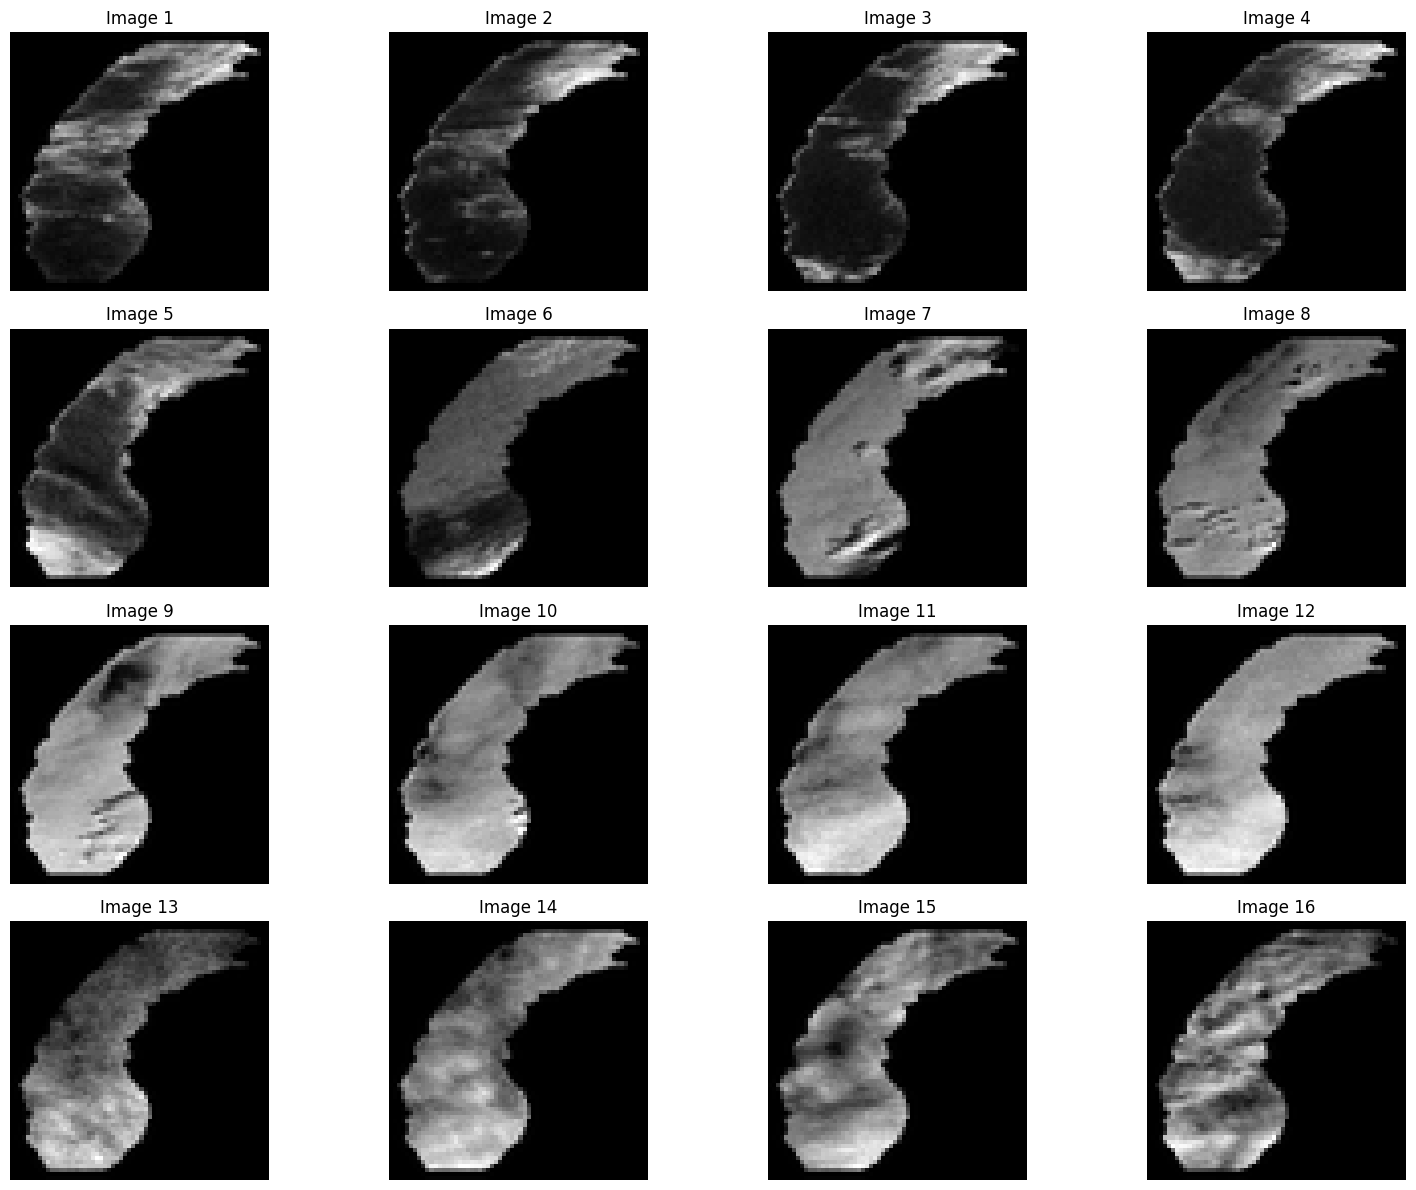

In [23]:
print("=== 48-Hour Model (manual class weights) Results: ===")
evaluate_model_with_sample(model_manual_weights_48, val_generator_48, class_names, 0)

#### Model Results

The model achieved an accuracy of 50% and a macro-average F1-score of 49%, with notable variability across classes. High Rain and No Rain performed the best, both achieving a recall of 63%, with F1-scores of 58% and 60%, respectively, demonstrating strong reliability in these categories.

However, Less Rain struggled with an F1-score of 37%, and Medium Rain showed moderate performance at 41%. These findings indicate that while our approach handles extreme cases well, distinguishing lighter rainfall categories remains a challenge.

#### Sample Prediction:

The model correctly classified a "High Rain" sample with a high predicted probability of 92.83%, indicating strong confidence in its prediction. Probabilities for other classes—1.16% for "Less Rain," 4.73% for "Medium Rain," and 1.27% for "No Rain"—were minimal, further reflecting the model's certainty.


### 7.5 72-Hour Window Model (Automatic Weights)

=== 72-Hour Model (automatic class weights) Results: ===
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 836ms/step

Classification Report:
               precision    recall  f1-score   support

   High Rain       0.56      0.74      0.64       126
   Less Rain       0.34      0.21      0.26       126
 Medium Rain       0.42      0.38      0.40       126
     No Rain       0.63      0.74      0.68       126

    accuracy                           0.52       504
   macro avg       0.49      0.52      0.49       504
weighted avg       0.49      0.52      0.49       504



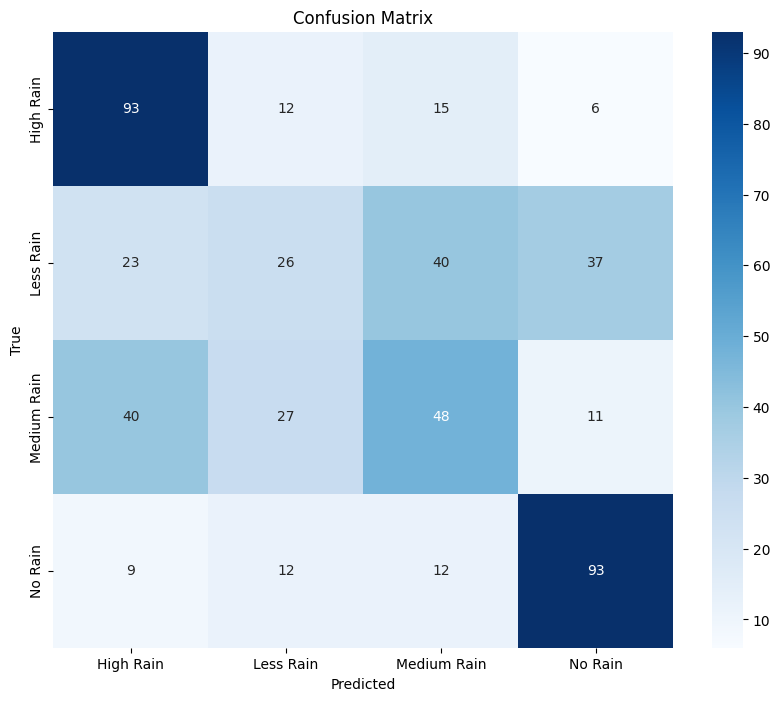


=== Sample Input and Prediction ===

True Label: High Rain
Predicted Label: High Rain
Predicted Probabilities: [0.37894216 0.31868    0.15279227 0.14958559]

Meteorological Data (Sample Input):


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,42.0,28.0,1031.500000,8.0,1032.099976,1008.299988,0.0,8.0,110.0,0.0
1,48.0,28.0,1031.199951,11.0,1031.599976,1008.000000,0.0,9.0,120.0,0.0
2,52.0,28.0,1031.500000,13.0,1032.099976,1008.299988,20000.0,9.0,130.0,0.0
3,33.0,36.0,1020.299988,10.0,1020.900024,997.299988,10000.0,11.0,130.0,20000.0
4,29.0,37.0,1020.700012,8.0,1021.099976,997.700012,12000.0,8.0,140.0,20000.0
...,...,...,...,...,...,...,...,...,...,...
67,78.0,36.0,1012.200012,30.0,1012.700012,989.299988,5000.0,0.0,0.0,7000.0
68,67.0,40.0,1012.200012,30.0,1012.599976,989.299988,4400.0,0.0,0.0,5500.0
69,69.0,39.0,1008.500000,30.0,1008.799988,985.700012,2500.0,3.0,0.0,0.0
70,69.0,39.0,1009.099976,30.0,1009.400024,986.400024,2300.0,11.0,220.0,0.0



Cloud Images (Sample Input):


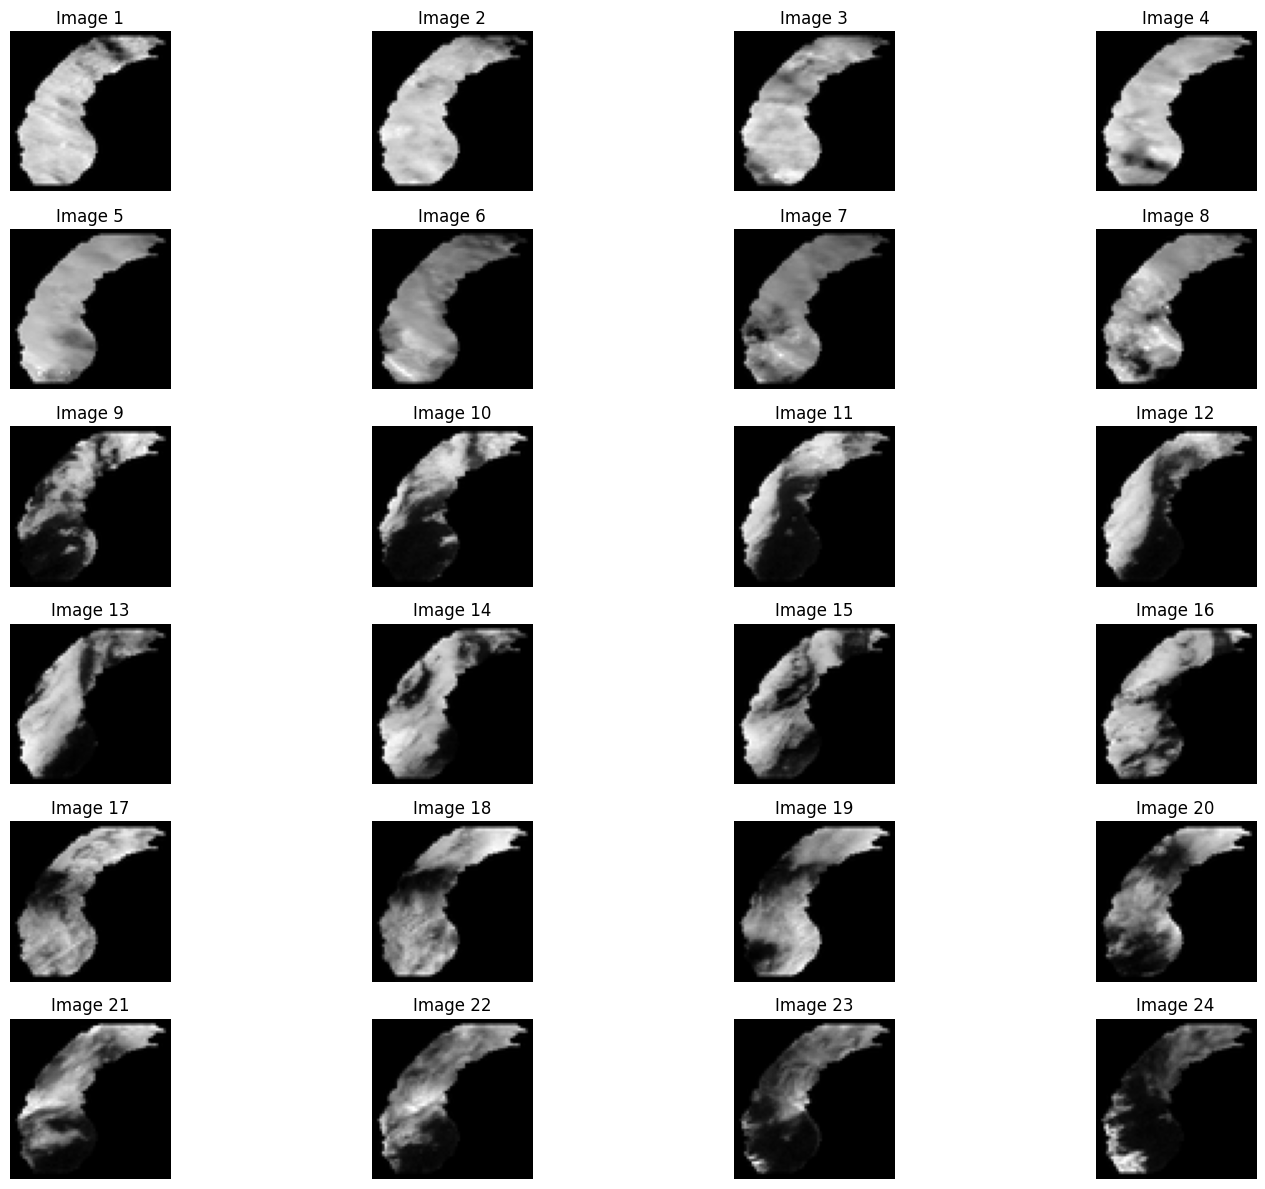

In [24]:
print("=== 72-Hour Model (automatic class weights) Results: ===")
evaluate_model_with_sample(model_automatic_weights_72, val_generator_72, class_names, 0)

#### Model Results

The 72-hour model with automatic weights achieved an accuracy of 52% and a macro-average F1-score of 49%, with variability across classes. High Rain and No Rain performed the best, with recalls of 74% and F1-scores of 64% and 68%, respectively, indicating strong reliability in these categories.

However, Less Rain struggled with an F1-score of 26%, and Medium Rain showed moderate performance at 40%. These results suggest that while the model excels in extreme cases, distinguishing lighter rainfall categories continues to be a challenge.

#### Sample Prediction

The model correctly classified a "High Rain" sample with a predicted probability of 37.89%, though it showed significant uncertainty, with 31.87% probability for "Less Rain." This highlights the model's challenge in confidently distinguishing between rain categories.

### 7.6 72-Hour Window Model (Manual Weights)

=== 72-Hour Model (manual class weights) Results: ===
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 826ms/step

Classification Report:
               precision    recall  f1-score   support

   High Rain       0.58      0.67      0.62       126
   Less Rain       0.33      0.31      0.32       126
 Medium Rain       0.42      0.34      0.38       126
     No Rain       0.62      0.67      0.64       126

    accuracy                           0.50       504
   macro avg       0.49      0.50      0.49       504
weighted avg       0.49      0.50      0.49       504



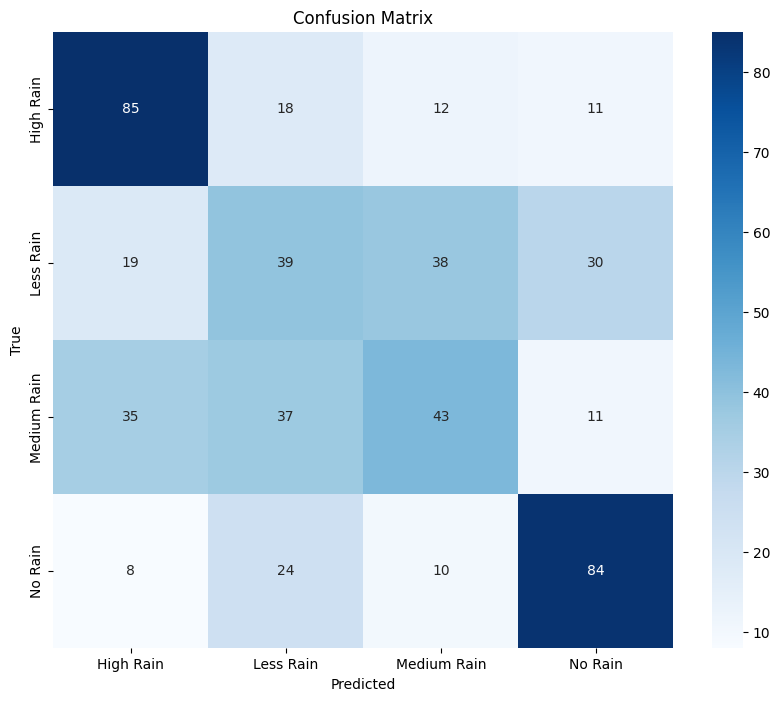


=== Sample Input and Prediction ===

True Label: High Rain
Predicted Label: High Rain
Predicted Probabilities: [0.5093894  0.3835896  0.04643354 0.06058742]

Meteorological Data (Sample Input):


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
0,42.0,28.0,1031.500000,8.0,1032.099976,1008.299988,0.0,8.0,110.0,0.0
1,48.0,28.0,1031.199951,11.0,1031.599976,1008.000000,0.0,9.0,120.0,0.0
2,52.0,28.0,1031.500000,13.0,1032.099976,1008.299988,20000.0,9.0,130.0,0.0
3,33.0,36.0,1020.299988,10.0,1020.900024,997.299988,10000.0,11.0,130.0,20000.0
4,29.0,37.0,1020.700012,8.0,1021.099976,997.700012,12000.0,8.0,140.0,20000.0
...,...,...,...,...,...,...,...,...,...,...
67,78.0,36.0,1012.200012,30.0,1012.700012,989.299988,5000.0,0.0,0.0,7000.0
68,67.0,40.0,1012.200012,30.0,1012.599976,989.299988,4400.0,0.0,0.0,5500.0
69,69.0,39.0,1008.500000,30.0,1008.799988,985.700012,2500.0,3.0,0.0,0.0
70,69.0,39.0,1009.099976,30.0,1009.400024,986.400024,2300.0,11.0,220.0,0.0



Cloud Images (Sample Input):


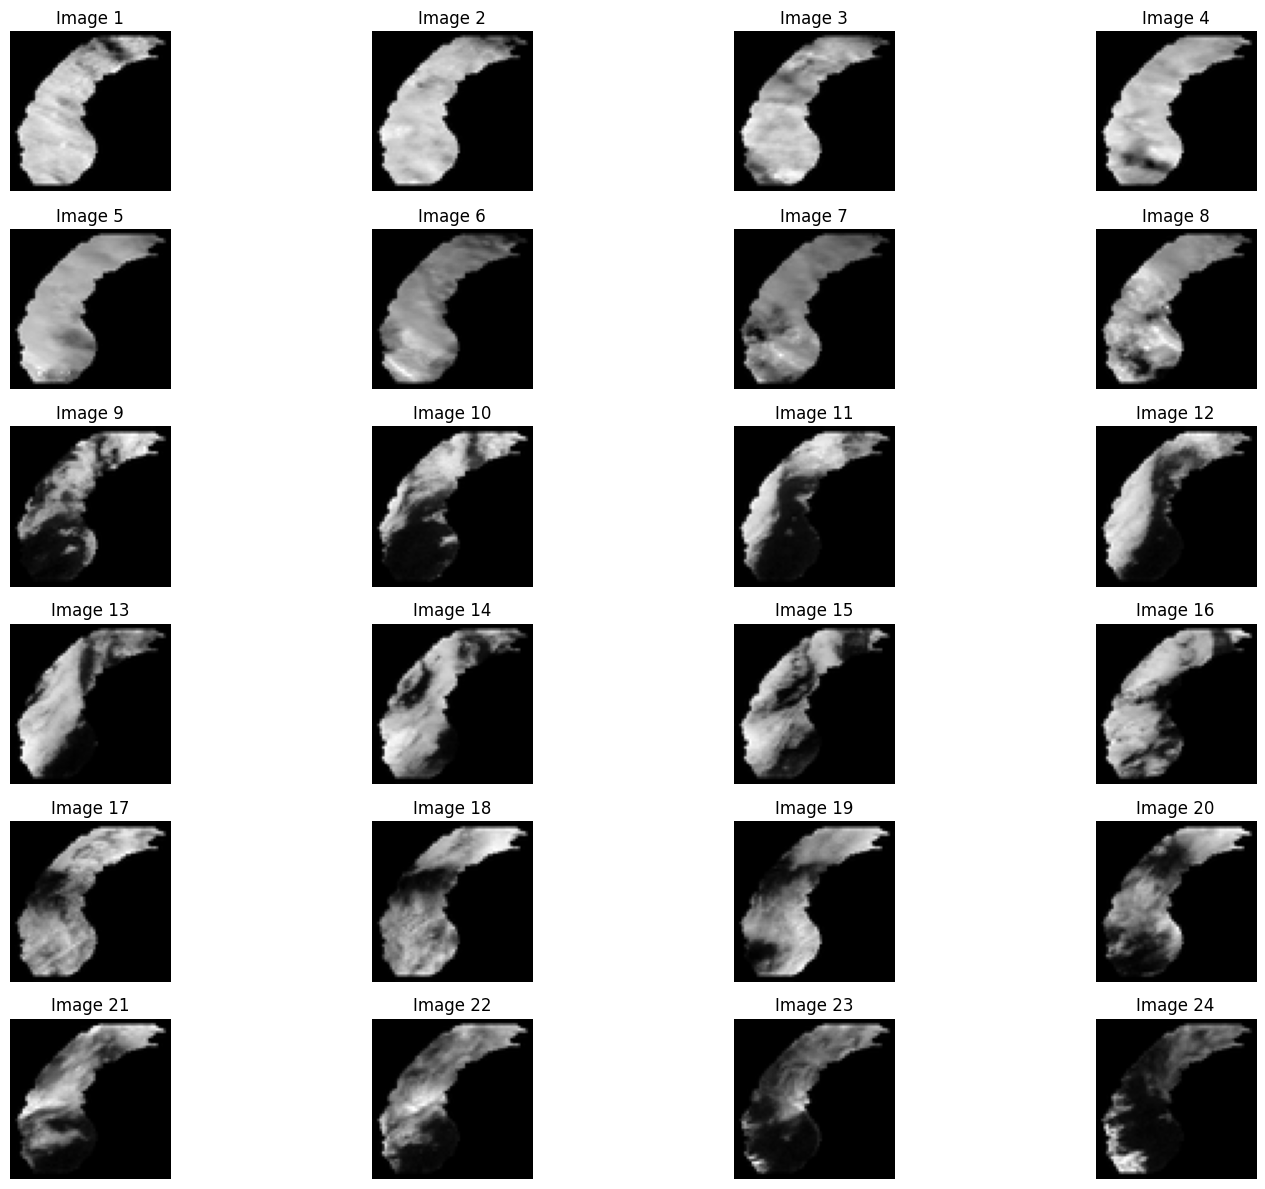

In [25]:
print("=== 72-Hour Model (manual class weights) Results: ===")
evaluate_model_with_sample(model_manual_weights_72, val_generator_72, class_names, 0)

#### Model Results

The 72-hour model with manual class weights achieved an accuracy of 50% and a macro-average F1-score of 49%, showing balanced performance across classes. High Rain and No Rain performed best, with F1-scores of 62% and 64%, respectively, and recalls of 67% for both.

However, Less Rain and Medium Rain struggled, with F1-scores of 32% and 38%, respectively, highlighting challenges in distinguishing lighter rainfall categories. These results indicate consistent performance in extreme cases, with room for improvement in handling mid-range predictions.

#### Sample Prediction

The model correctly classified a "High Rain" sample with a predicted probability of 50.94%, though it showed considerable uncertainty, assigning 38.36% probability to "Less Rain." Probabilities for "Medium Rain" (4.64%) and "No Rain" (6.06%) were minimal.

# Conclusion


<div style="text-align: center;">
    <img src="images\conclusion.jpg" width="700" />
</div>


**What has been the conclusion of our investigation into the mystery of predicting rainfall?**

Our analysis of six hybrid models has provided valuable insights into the complexities of forecasting rainfall using a combination of meteorological data and satellite imagery. By exploring models across three prediction windows—24-hour, 48-hour, and 72-hour—and two weighting strategies, we uncovered key factors influencing performance.

**Which models performed the best?**
The 48-hour model with automatic class weights consistently stood out as the top performer. This model struck an optimal balance, capturing meaningful trends in rainfall patterns without the excessive uncertainty associated with longer timeframes. Its ability to dynamically adjust for class imbalances further enhanced its performance, particularly in extreme categories like "High Rain" and "No Rain."

**Why do we think the 48-Hour Window Model managed to excel in this scenario?**
- Prediction Window: The 48-hour window provided a sweet spot—long enough to capture meaningful temporal trends but not so far ahead that the data lost its predictive value.
- Automatic Class Weights: These models adapted effectively to imbalances in the dataset, ensuring underrepresented categories received appropriate attention without overcompensating.
- Hybrid Architecture: The integration of ConvLSTM for satellite data and LSTM with attention for meteorological data enabled the models to capture complex spatiotemporal patterns, leading to robust predictions for extreme cases.

**Where have the models struggled the most?**
- "Less Rain" remained a challenging category across all models, with low recall and F1-scores. This difficulty likely arises from overlapping features with other categories and inherent noise in the data.
- 72-hour models struggled with accuracy in lighter rainfall categories, as uncertainty increased with longer prediction windows.


In our quest to unravel the mystery of rainfall prediction, the 48-hour automatic weight model emerged as our most reliable detective, offering a glimpse into the future with balanced precision and recall. While challenges remain, this investigation has laid a strong foundation for advancing hybrid meteorological forecasting.

# Challenges Experienced During the Journey

<div style="text-align: center;">
    <img src="images\challenges.jpeg" width="700" />
</div>

- **Imbalanced Dataset:**
The highly imbalanced nature of the time-series dataset posed significant challenges. To address this, we experimented extensively with different sampling techniques and built close to 7 RNN-based models to find the optimal approach. This was a time-intensive process, requiring careful tuning and validation to ensure balanced performance across all rainfall categories.

- **Multiple Hybrid Models:**
The requirement to predict rainfall across different windows—24-hour, 48-hour, and 72-hour—each with varying prediction shifts, necessitated the development of multiple hybrid models. Each model came with its own set of experiments, architectures, and optimizations, adding to the complexity of the project.

- **Technical Limitations on MacOS, and GPU problems on Windows:**
Working with TensorFlow on macOS introduced unexpected hurdles, particularly with TensorFlow failing to recognize dedicated GPUs. As a result, we faced long training times, as computations had to be run purely on CPUs. This slowed down experimentation significantly and added an extra layer of logistical difficulty in managing and testing multiple models.

Despite these challenges, the journey has been a rewarding one, filled with lessons that will inform future work in hybrid meteorological forecasting.